In [1]:
# Import necessary libraires
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings  #ignore warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## Feature Engineering

In [4]:
# Convert InvoiceDate to DateTime format
train_df['datetime'] = pd.to_datetime(train_df['datetime'], format='mixed', dayfirst = False)

In [5]:
# Extract Years from the datetime
train_df['year'] = train_df['datetime'].dt.year

# Extract Months from the datetime
train_df['month'] = train_df['datetime'].dt.month

# Extract Days from the datetime
train_df['day'] = train_df['datetime'].dt.day

# Extract Hours from the datetime
train_df['hour'] = train_df['datetime'].dt.hour

In [6]:
# Rearrange Columns
train_df.insert(1, 'year', train_df.pop('year'))
train_df.insert(2, 'month', train_df.pop('month'))
train_df.insert(3, 'day', train_df.pop('day'))
train_df.insert(4, 'hour', train_df.pop('hour'))

In [7]:
train_df[['year', 'day', 'month', 'hour']]

,year,day,month,hour
0,2011,1,1,0
1,2011,1,1,1
2,2011,1,1,2
3,2011,1,1,3
4,2011,1,1,4
...,...,...,...,...
10881,2012,19,12,19
10882,2012,19,12,20
10883,2012,19,12,21
10884,2012,19,12,22


In [8]:
# Count missing values in each column
missing_values = train_df.isnull().sum()
print(missing_values)

datetime      0
year          0
month         0
day           0
hour          0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


### Check for Duplicate Rows

In [10]:
duplicated_rows = train_df[train_df.duplicated()]

duplicated_rows

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


### Checking out Outliers

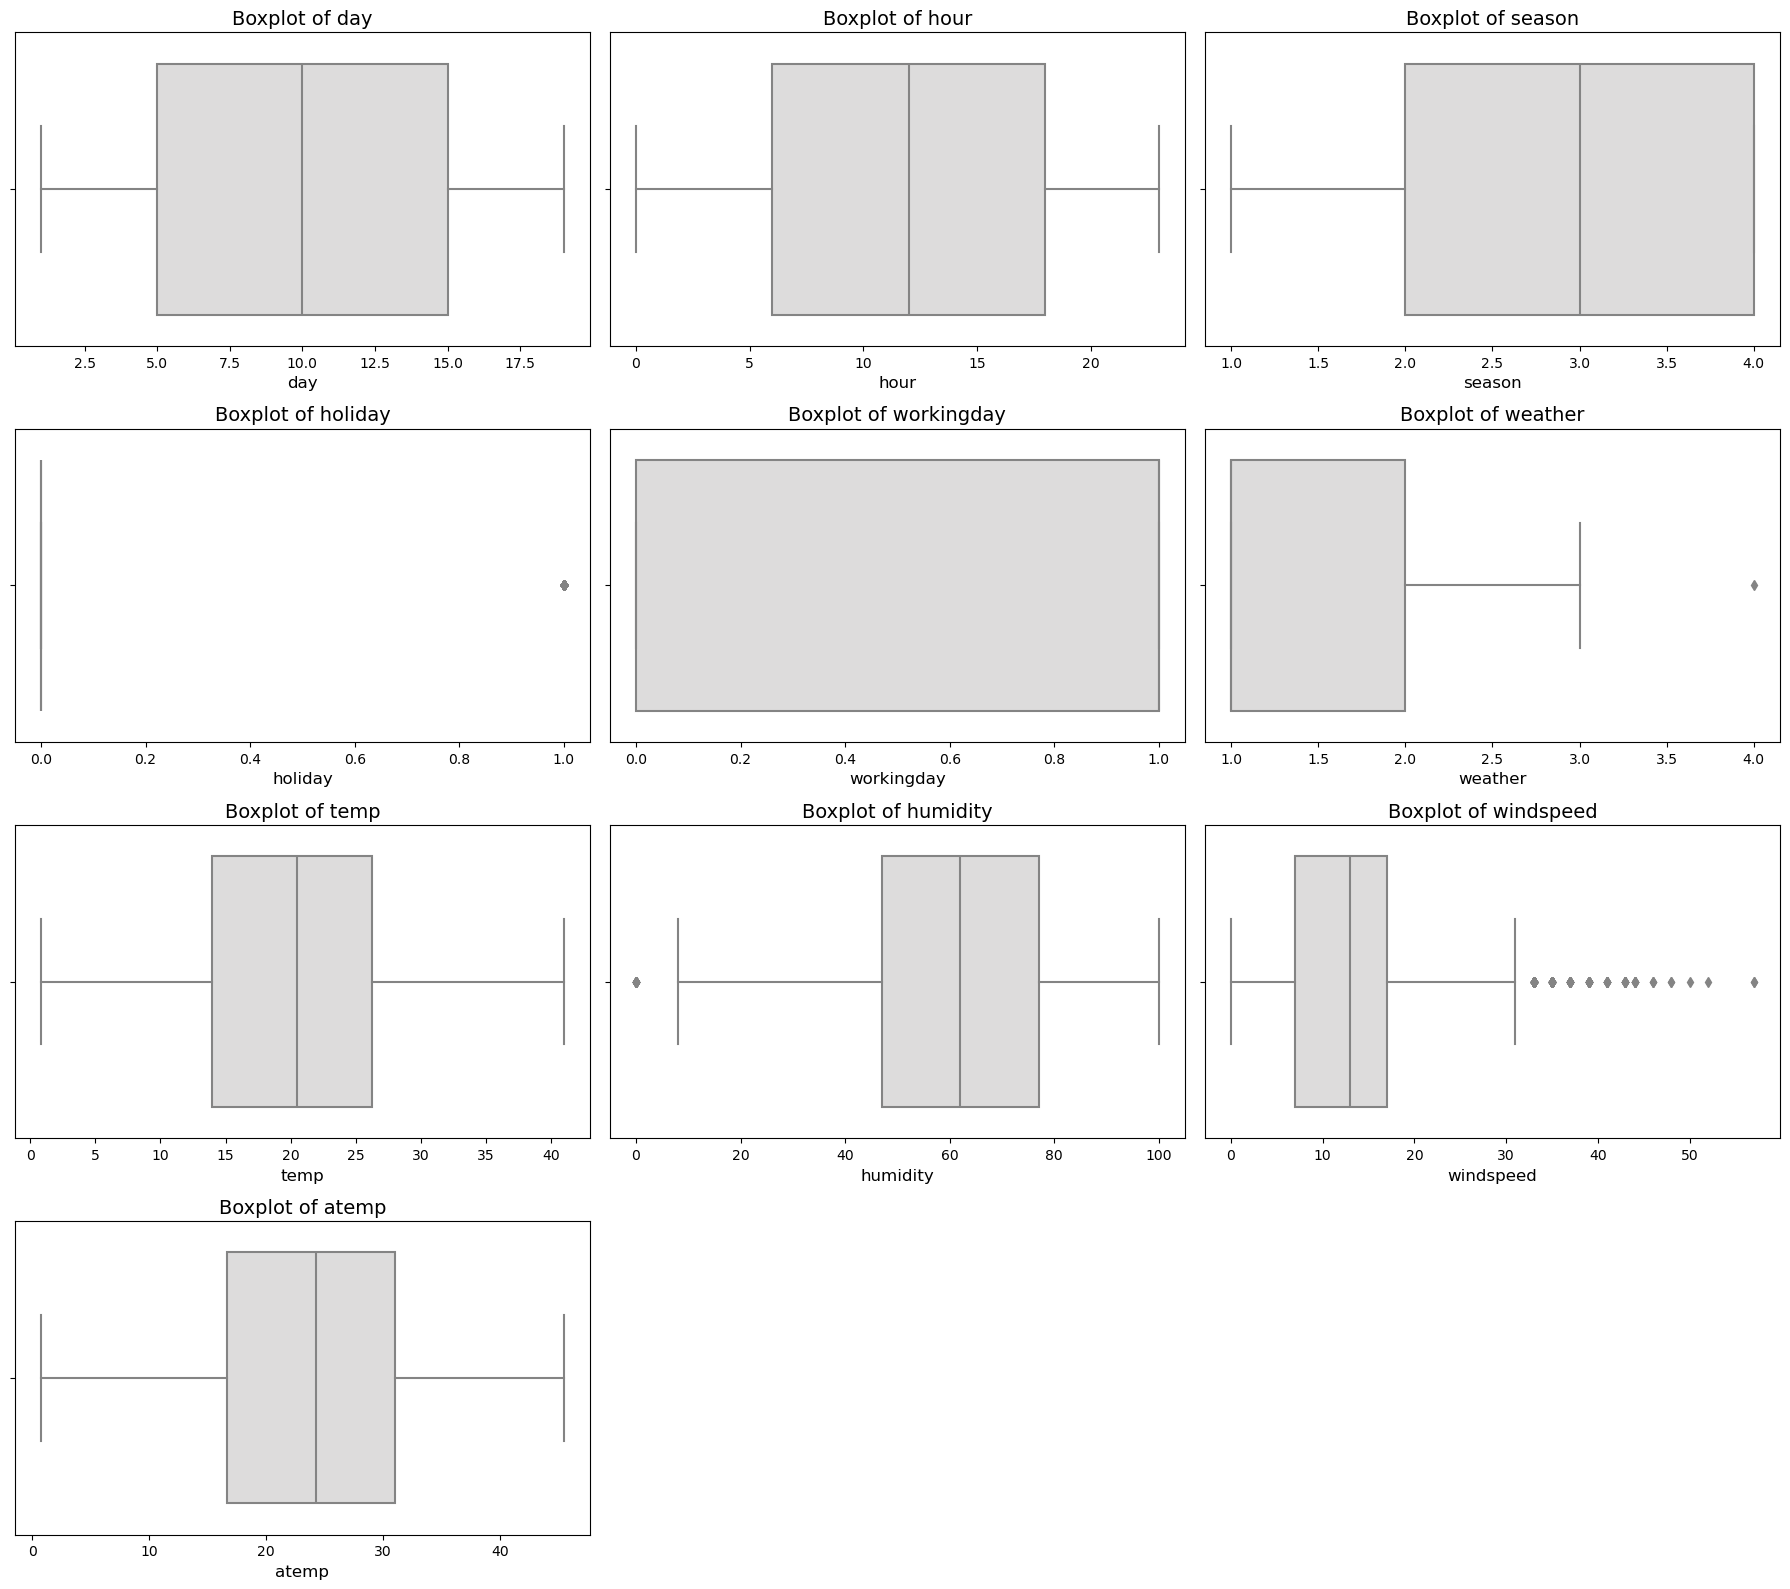

In [12]:
numerical_features = ['day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'atemp']

# Setting up a grid layout for 3 plots per row
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=train_df, x=feature, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].tick_params(labelsize=10)

# Remove extra subplots (if any)
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

# Save the plot as image
plt.savefig('bike_rental_check_outliers_distribution.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

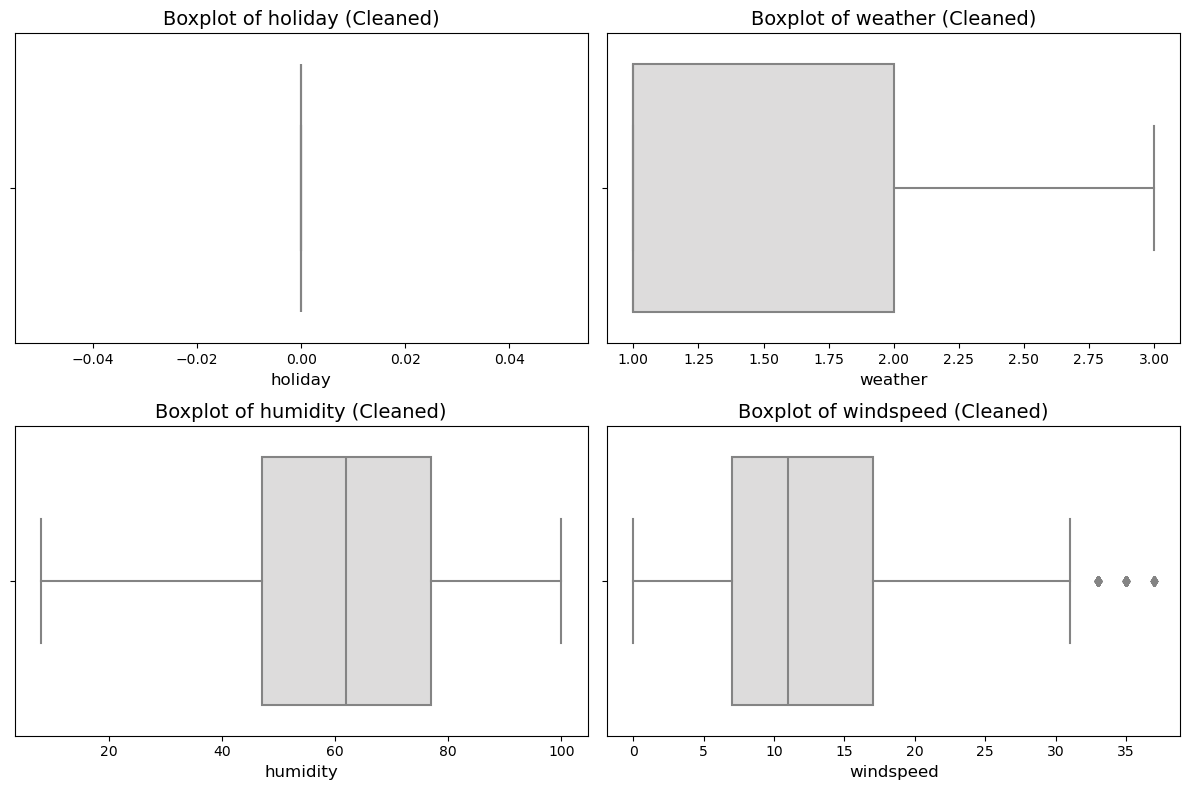

In [13]:
from scipy.stats import zscore

# Columns for outlier removal
columns_to_check = ['holiday', 'weather', 'humidity', 'windspeed']

# Calculate Z-scores for the specified columns
z_scores = np.abs(zscore(train_df[columns_to_check]))

# Create a mask for rows with all Z-scores <= 3 (not outliers)
non_outlier_mask = (z_scores <= 3).all(axis=1)

# Filter the DataFrame to remove outliers
cleaned_df = train_df[non_outlier_mask]

# Plot new boxplots for the removed outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot boxplots for the affected features

for i, feature in enumerate(columns_to_check):
    sns.boxplot(data=cleaned_df, x=feature, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} (Cleaned)', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].tick_params(labelsize=10)

# Save the plot as image
plt.savefig('bike_rental_outliers_removed_distribution.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [14]:
# Return cleaned dataset to the original dataset
train_df = cleaned_df

## Statistical Description of the Dataframe

In [16]:
train_df.describe()

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10487,10487.00000,10487.000000,10487.000000,10487.000000,10487.000000,10487.0,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000,10487.000000
mean,2011-12-27 23:15:18.279774976,2011.50205,6.543721,9.996853,11.526271,2.509393,0.0,0.700677,1.413846,20.252757,23.690451,62.088681,12.595891,35.754458,156.459712,192.214170
min,2011-01-01 00:00:00,2011.00000,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.820000,0.760000,8.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 05:30:00,2011.00000,4.000000,5.000000,6.000000,2.000000,0.0,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,37.000000,43.000000
50%,2012-01-01 21:00:00,2012.00000,7.000000,10.000000,12.000000,3.000000,0.0,1.000000,1.000000,20.500000,24.240000,62.000000,11.001400,17.000000,119.000000,146.000000
75%,2012-07-01 08:30:00,2012.00000,10.000000,15.000000,18.000000,4.000000,0.0,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,48.000000,223.000000,284.000000
max,2012-12-19 23:00:00,2012.00000,12.000000,19.000000,23.000000,4.000000,0.0,1.000000,3.000000,41.000000,45.455000,100.000000,36.997400,367.000000,886.000000,977.000000
std,NaN,0.50002,3.432765,5.488018,6.922988,1.113218,0.0,0.457983,0.629698,7.763801,8.431030,19.044758,7.837985,49.643412,151.911683,181.725307


### Rental Count Distribution

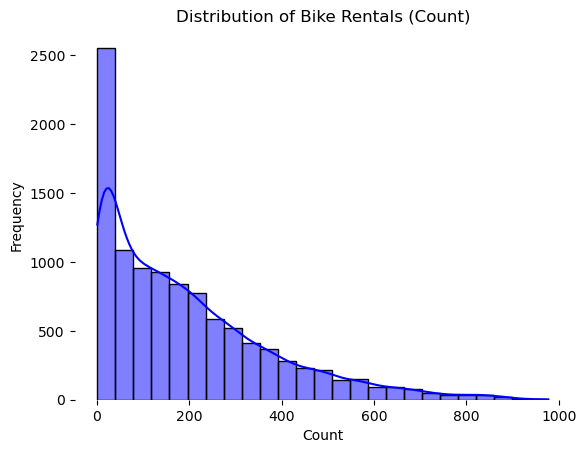

In [18]:
# Distribution of the target variable
sns.histplot(train_df['count'], kde=True, bins=25, color='blue')
sns.despine(left=True, bottom=True)



plt.title('Distribution of Bike Rentals (Count)')
plt.xlabel('Count')
plt.ylabel('Frequency')

# Save the plot as image
plt.savefig('bike_rental_count_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

### Bike Rental by Year

year
2011    5222
2012    5265
Name: count, dtype: int64


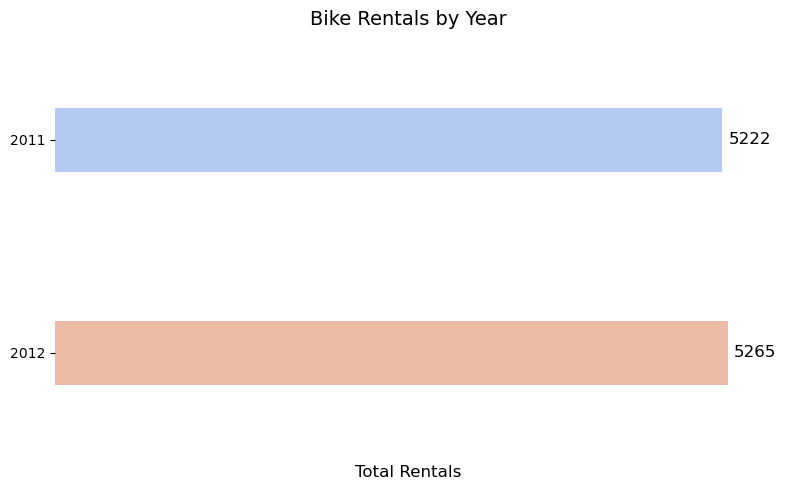

In [20]:
# Year count data
year_counts = train_df['year'].value_counts().sort_index()
print(year_counts)

# Plot bike rentals by year as a horizontal bar plot
fig, ax = plt.subplots(figsize=(8, 5))

# Create a horizontal bar plot
barplot = sns.barplot(y=year_counts.index, x=year_counts.values, palette='coolwarm', orient='h', width=0.3)

# Add text labels to the end of each bar
for index, value in enumerate(year_counts.values):
    ax.text(value + 50, index, str(value), va='center', fontsize=12, color='black')

# Customize the plot
#ax.set_facecolor('#eeeeee')
sns.despine(left=True, bottom=True)
plt.title('Bike Rentals by Year', fontsize=14)
plt.xlabel('Total Rentals', fontsize=12)
plt.ylabel('')  # Remove y-axis label
plt.xticks([])
plt.yticks(ticks=range(len(year_counts.index)), labels=year_counts.index, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

### Distribution of Numerical Features

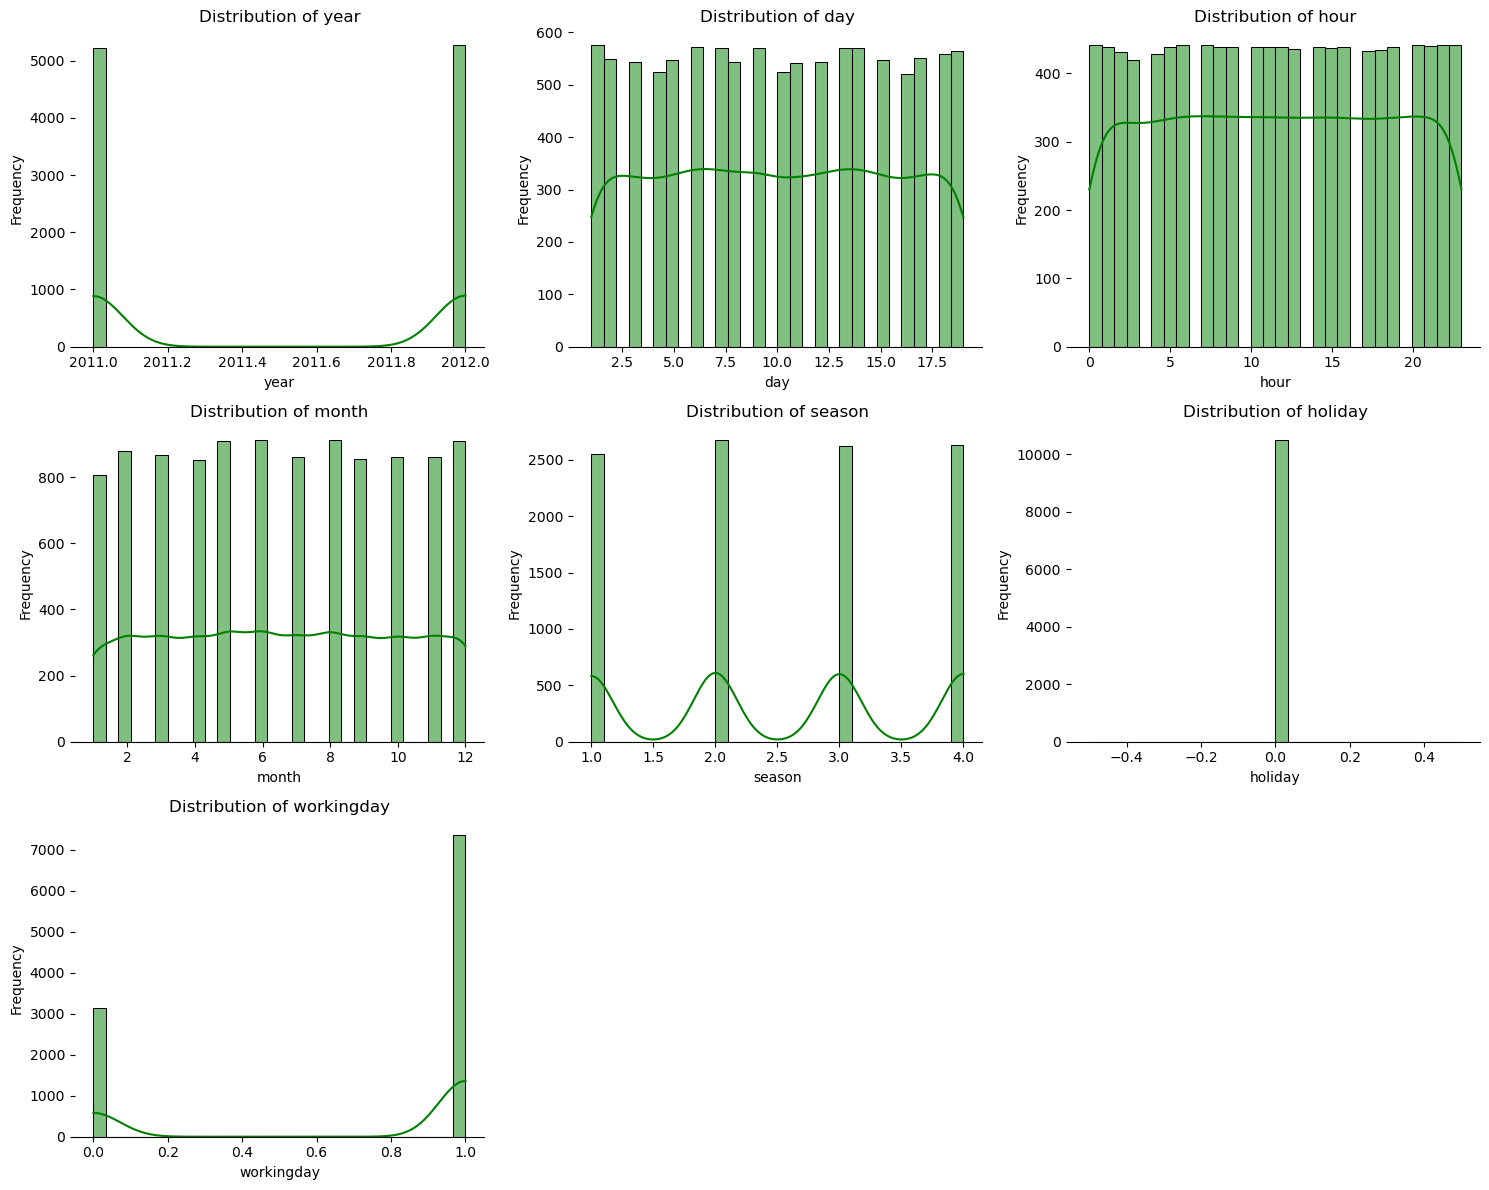

In [22]:
# Select of numerical features
seasonal_features = ['year', 'day', 'hour', 'month', 'season', 'holiday', 'workingday']

# Plot distribution of numerical features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(seasonal_features):
    sns.histplot(train_df[feature], kde=True, color='green', bins=30, ax=axes[i])
    sns.despine(left=True, bottom=False)
    
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove extra subplots (if any)
for j in range(len(seasonal_features), len(axes)):
    fig.delaxes(axes[j])
    
# Save the plot as image
plt.savefig('bike_rental_numerical_features_distribution.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

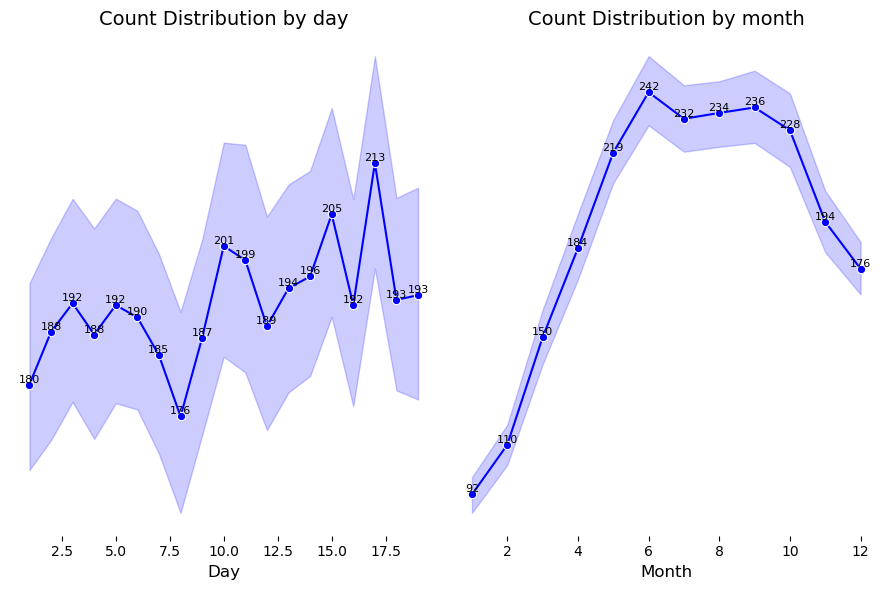

In [23]:
# Select time-related features
time_features = ['day', 'month']

# Initialize a grid layout for subplots
fig, axes = plt.subplots(1,2, figsize=(9, 6))
axes = axes.flatten()

# Plot the distribution of counts against each time feature
for i, feature in enumerate(time_features):
    # Line plot for counts
    sns.lineplot(data=train_df, x=feature, y='count', ax=axes[i], marker='o', color='blue')
    
    # Add text labels for each unique point
    grouped = train_df.groupby(feature)['count'].mean().reset_index()  # Average counts per feature
    for x, y in zip(grouped[feature], grouped['count']):
        axes[i].text(x, y, f'{y:.0f}', fontsize=8, color='black', ha='center', va='bottom')
    
    # Customize the subplot
    sns.despine(left=True, bottom=True, ax=axes[i])
    axes[i].set_title(f'Count Distribution by {feature}', fontsize=14)
    axes[i].set_xlabel(feature.capitalize(), fontsize=12)
    axes[i].set_ylabel('')
    axes[i].set_yticks([])
    axes[i].tick_params(labelsize=10)

    if feature == 'year':
        axes[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

# Remove extra subplots (if any)
for j in range(len(time_features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Distribution of the Weather Features

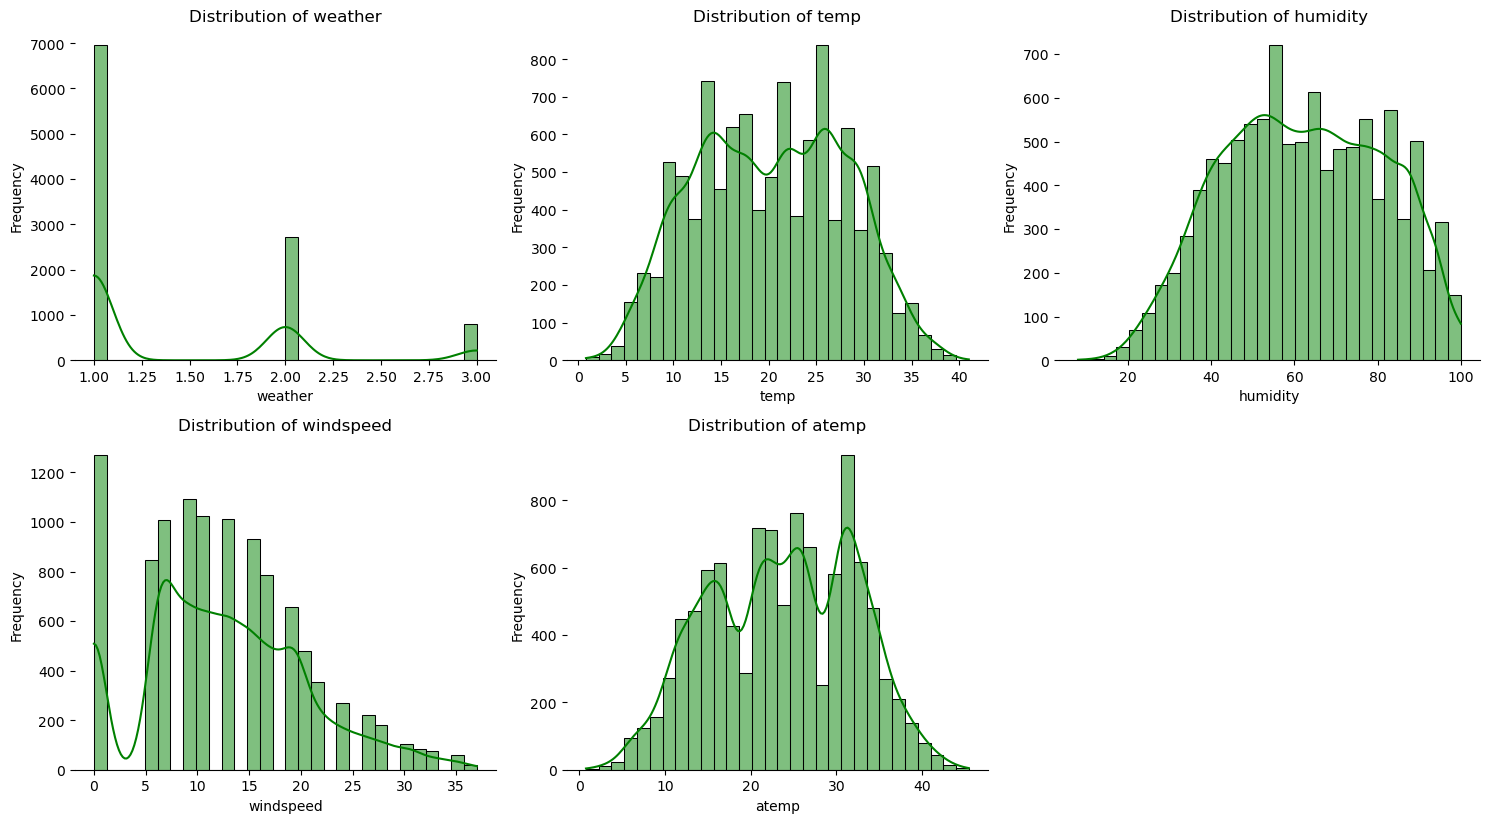

In [25]:
weather_features = ['weather', 'temp', 'humidity', 'windspeed', 'atemp']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(weather_features):
    sns.histplot(train_df[feature], kde=True, color='green', bins=30, ax=axes[i])
    sns.despine(left=True, bottom=False)
    
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove extra subplots (if any)
for j in range(len(weather_features), len(axes)):
    fig.delaxes(axes[j])

# Save the plot as image
plt.savefig('bike_rental_weather_features_distribution.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Rentals by Months and Year

In [27]:
#yearly_monthly = train_df.groupby(['hour', 'year'])['count'].mean().reset_index()
#sorted_yearly_monthly = yearly_monthly.sort_values(by='count', ascending=False)

#sorted_yearly_monthly

AttributeError: 'numpy.int32' object has no attribute 'startswith'

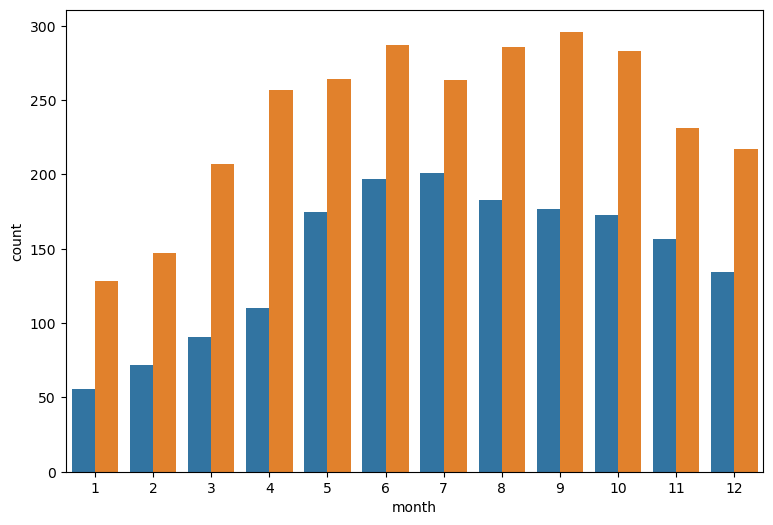

In [28]:
# Plot by Months and Years
plt.figure(figsize=(9, 6))

# Get a reference to the axes
ax = plt.gca()

sns. barplot(data=train_df, x='month', y='count', hue='year', ci=None)
sns.despine(left=True, bottom=True)

# Annotate the text value at the top of each bar
for i, patch in enumerate(ax.patches):
    label = '{:.0f}'.format(patch.get_height())
    if i % 2 == 0: # Even patch (bottom bar in each month)
        y = patch.get_height() + 10
    else:  # Odd patch (top bar in each month)
        y = patch.get_height() - 5
    ax.text(patch.get_x() + patch.get_width()/2., y, label, verticalalignment='center', 
                 horizontalalignment='center', rotation=45, fontsize=8, color='black', ha='right')

plt.title('Bike Rentals by Year')
plt.xlabel('Month')
plt.ylabel('')
plt.yticks([])

# Save the plot as image
plt.savefig('month_count_by_year.png', dpi=300, bbox_inches='tight')

plt.show()

### Hourly Bike Rentals

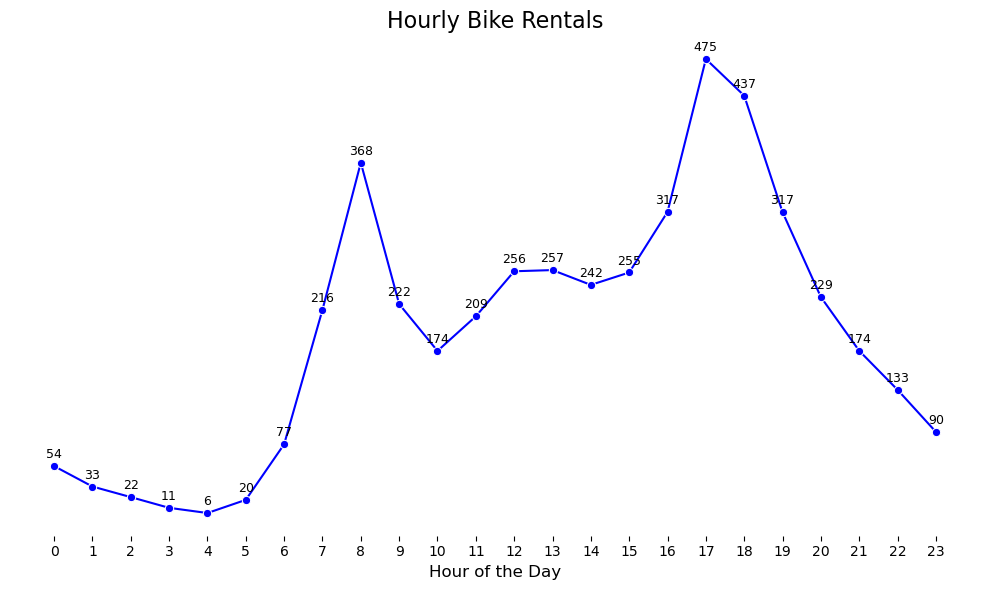

In [51]:
hourly_rentals = train_df.groupby('hour')['count'].mean()

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_rentals.index, y=hourly_rentals.values, marker='o', color='blue')

# Annotate the points on the plot
for x, y in zip(hourly_rentals.index, hourly_rentals.values):
    plt.text(x, y + 5, f'{int(y):,}', ha='center', va='bottom', fontsize=9)

# Customize the plot
sns.despine(left=True, bottom=True)
plt.title('Hourly Bike Rentals', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xticks(range(0, 24), fontsize=10)
plt.yticks([])
plt.grid(False)

# Save the plot as image
plt.savefig('bike_rental_by_hour.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

### Rentals by Day of the Week

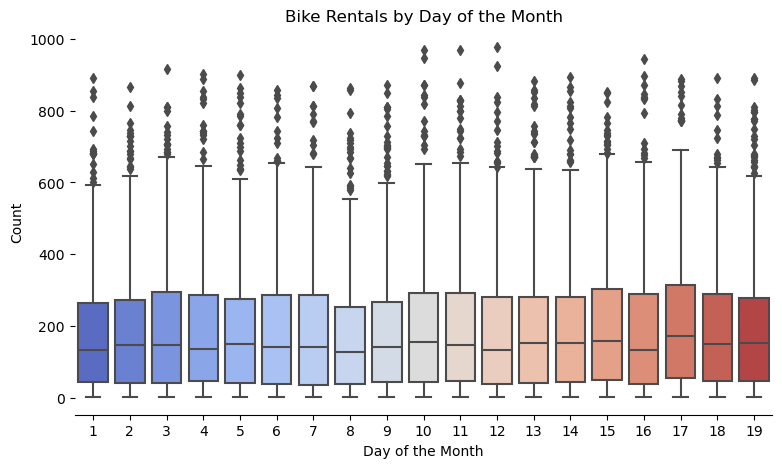

In [53]:
# Plot rentals by Day of the Week
plt.figure(figsize=(9, 5))

sns.boxplot(data=train_df, x='day', y='count', palette='coolwarm')
sns.despine(left=True, bottom=False)

plt.title('Bike Rentals by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.grid(False)

# Save the plot as image
plt.savefig('bike_rental_day_of_week.png', dpi=300, bbox_inches='tight')

plt.show()

### Average Bike Rentals by Hour and Day of Week

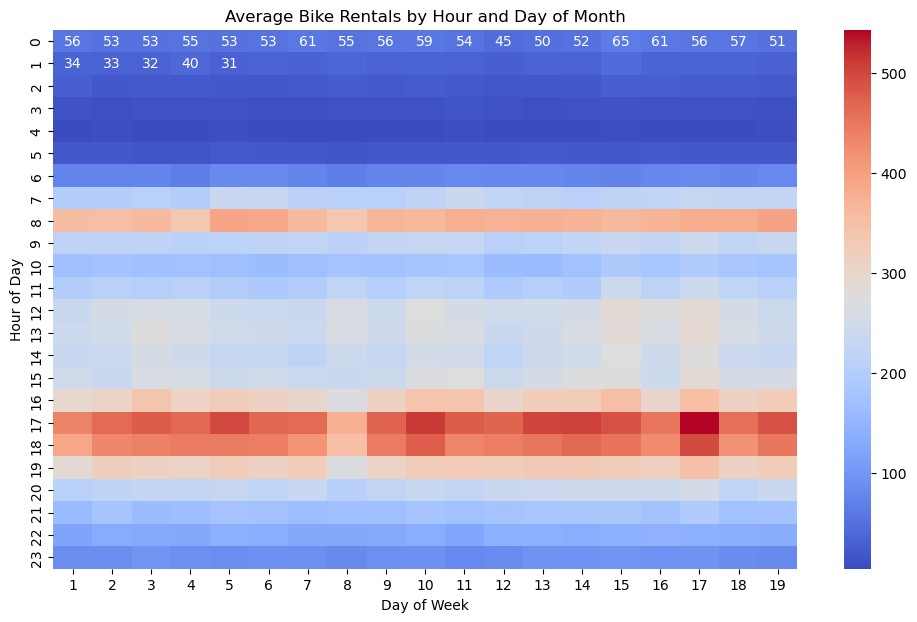

In [55]:
# Plot heatmap of hour vs day_of_week for rentals
plt.figure(figsize=(12, 7))

hourly_rentals = train_df.pivot_table(values='count', index='hour', columns='day', aggfunc='mean')
sns.heatmap(hourly_rentals, cmap='coolwarm', annot=True, fmt='.0f')

plt.title('Average Bike Rentals by Hour and Day of Month')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')

# Save the plot as image
plt.savefig('bike_rental_vs_hours_vs_day_of_week.png', dpi=300, bbox_inches='tight')

plt.show()

### Bike Rental by Working Days

AttributeError: 'numpy.int64' object has no attribute 'startswith'

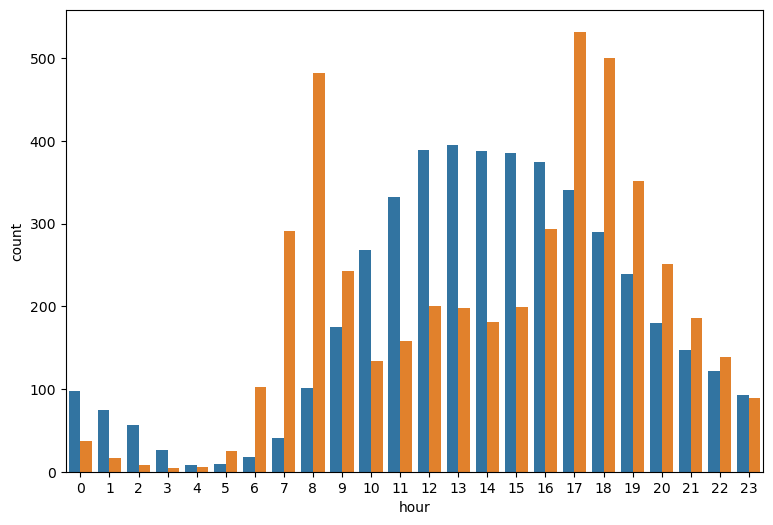

In [57]:
# Rentals by Hour
plt.figure(figsize=(9, 6))

# Get a reference to the axes
ax = plt.gca()

# Create the bar plot
sns.barplot(data=train_df, x='hour', y='count', hue='workingday', ci=None)

# Annotate the text value inside each bar
for patch in ax.patches:
    label = '{:.0f}'.format(patch.get_height())
    ax.text(patch.get_x() + patch.get_width()/2., patch.get_height()/2., label, 
                 verticalalignment='center', rotation=90, fontsize=8, color='black')

sns.despine(left=True, bottom=True)

plt.title('Bike Rentals by Hour (Working vs Non-Working Days)')
plt.xlabel('Hour of Day')
plt.ylabel('')
plt.yticks([])

# Save the plot as image
plt.savefig('bike_rental_vs_hour_vs_working_days.png', dpi=300, bbox_inches='tight')

plt.show()

### Bike Rentals by Season

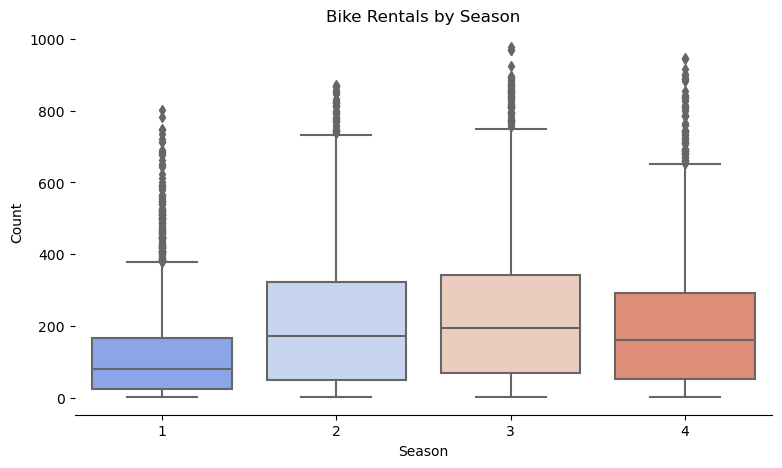

In [78]:
# Plot rental by Seasons

plt.figure(figsize=(9, 5))

sns.boxplot(data=train_df, x='season', y='count', palette='coolwarm')
sns.despine(left=True, bottom=False)

plt.title('Bike Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.grid(False)

# Save the plot as image
plt.savefig('bike_rental_vs_season.png', dpi=300, bbox_inches='tight')

plt.show()

### Bike Holiday Rentals

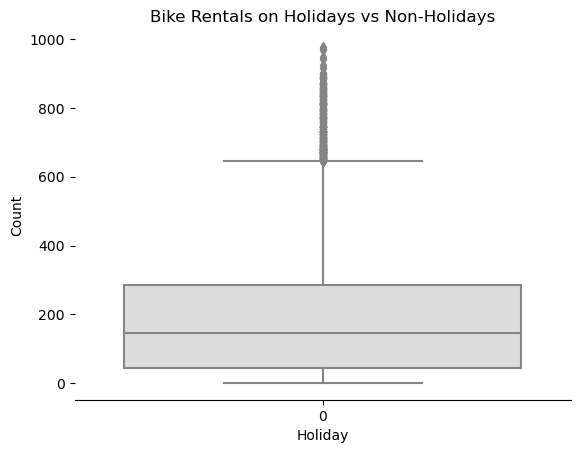

In [80]:
# Analyze rentals on holidays vs working days
sns.boxplot(data=train_df, x='holiday', y='count', palette='coolwarm')
sns.despine(left=True, bottom=False)

plt.title('Bike Rentals on Holidays vs Non-Holidays')
plt.xlabel('Holiday')
plt.ylabel('Count')
plt.show()

### Analysing Weather Features Correlation

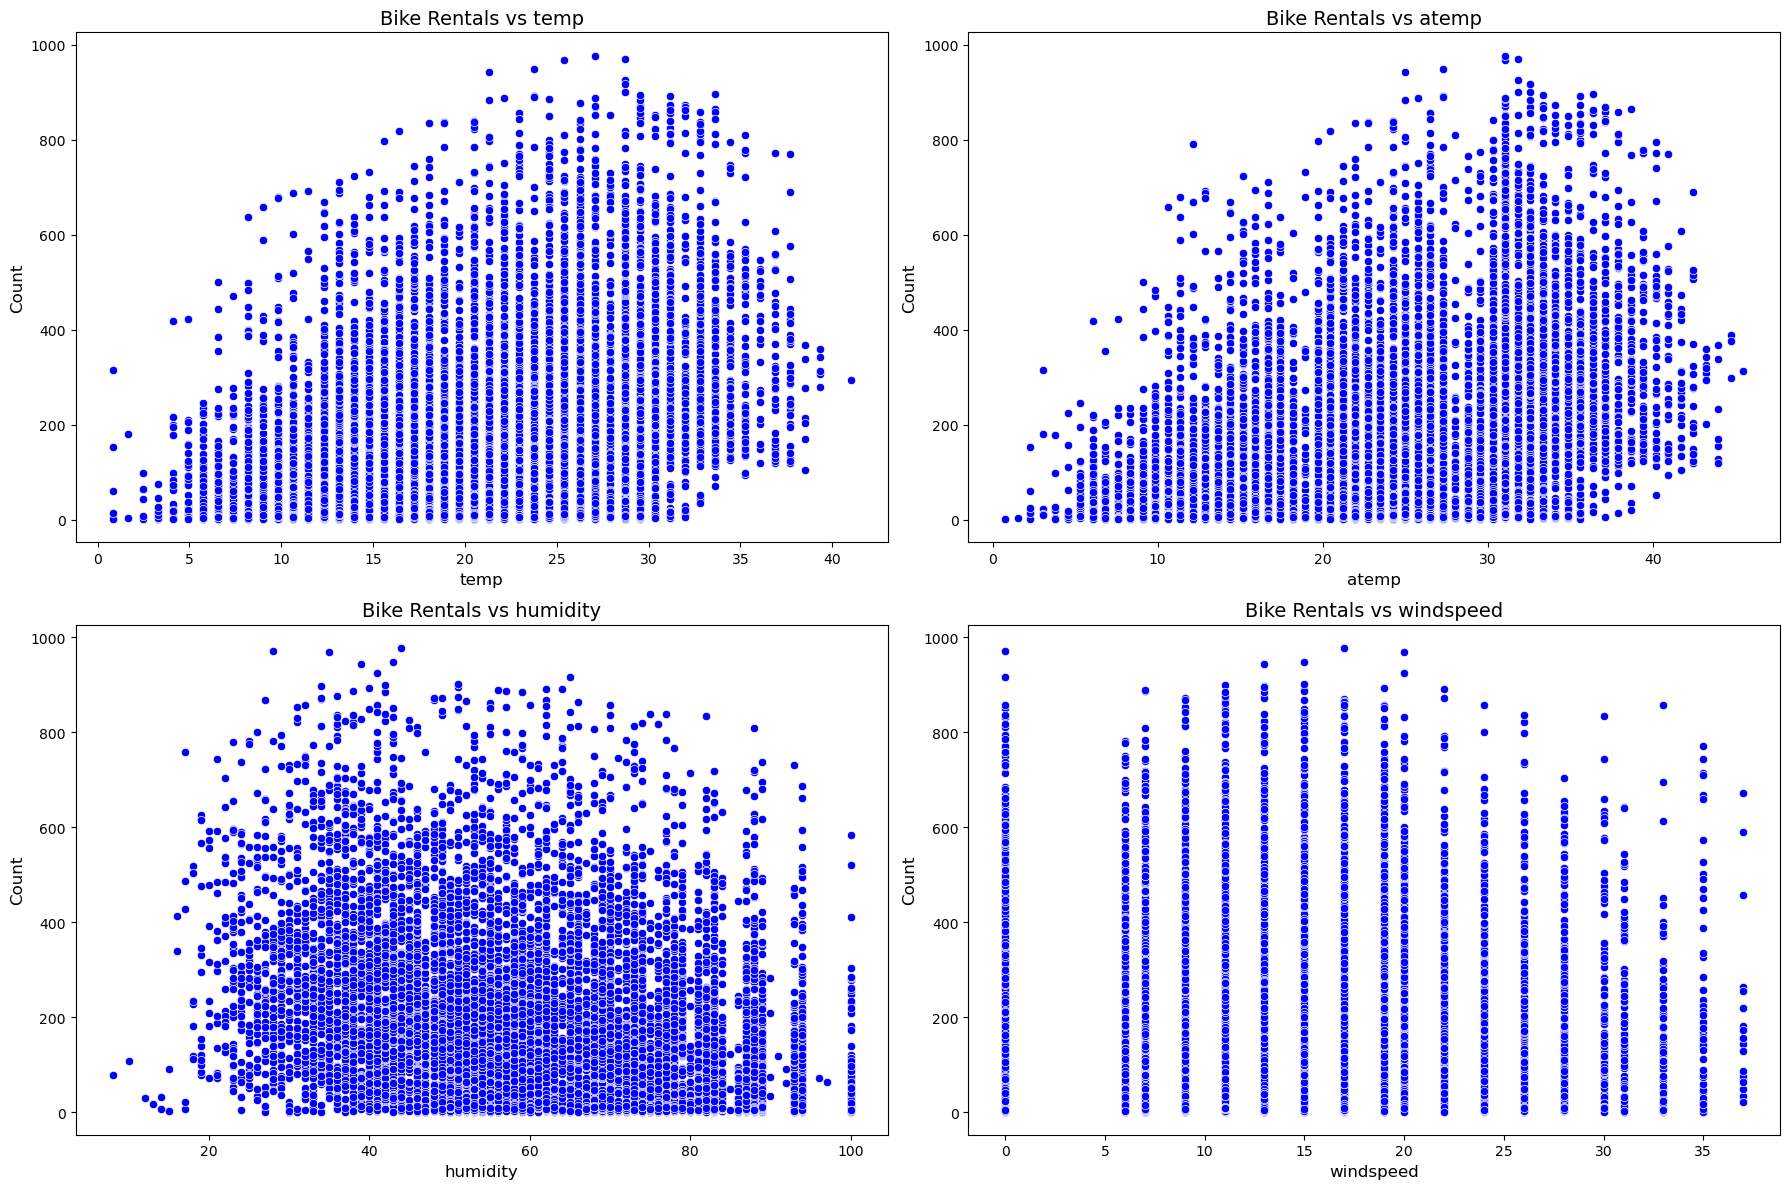

In [82]:
# Scatterplots for key correlations
key_features = ['temp', 'atemp', 'humidity', 'windspeed']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.scatterplot(data=train_df, x=feature, y='count', ax=axes[i], color='blue')
    
    axes[i].set_title(f'Bike Rentals vs {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(labelsize=10)
    axes[i].grid(False)

# Remove extra subplots (if any)
for j in range(len(key_features), len(axes)):
    fig.delaxes(axes[j])

# Save the plot as image
plt.savefig('bike_rental_vs_weather_features_correlation.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Bike Rental by Weather

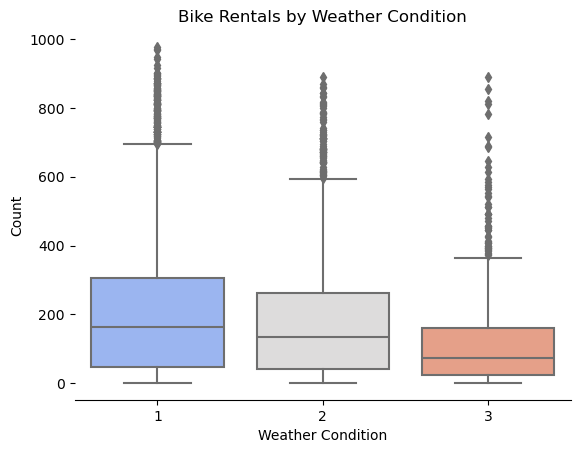

In [84]:
# Rentals by weather
sns.boxplot(data=train_df, x='weather', y='count', palette='coolwarm')
sns.despine(left=True, bottom=False)

plt.title('Bike Rentals by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.grid(False)

# Save the plot as image
plt.savefig('bike_vs_rental_weather_features.png', dpi=300, bbox_inches='tight')

plt.show()

### Analyzing Bike Rental During Different Weather in Each Month

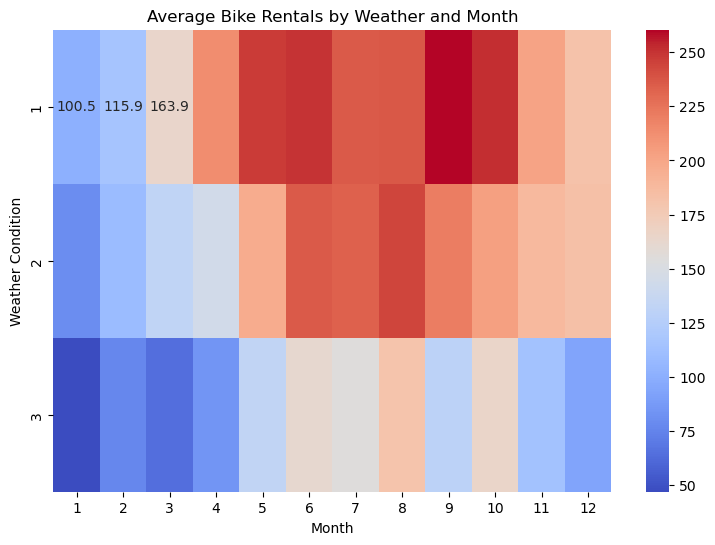

In [86]:
# Aggregate data by month and weather features
plt.figure(figsize=(9, 6))
monthly_weather = train_df.groupby(['month', 'weather'])['count'].mean().round(2).reset_index()

#print(monthly_weather)

# Heatmap for weather vs month
pivot_weather = monthly_weather.pivot(index='weather', columns='month', values='count')
sns.heatmap(pivot_weather, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Average Bike Rentals by Weather and Month')
plt.xlabel('Month')
plt.ylabel('Weather Condition')

# Save the plot as image
plt.savefig('bike_rental_weather_features_month.png', dpi=300, bbox_inches='tight')

plt.show()

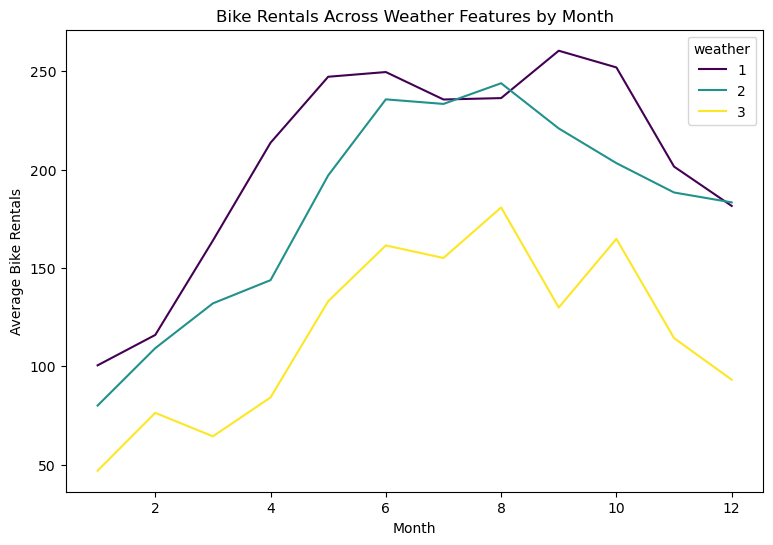

In [87]:
# Line plot for weather impact over months
plt.figure(figsize=(9, 6))

sns.lineplot(data=monthly_weather, x='month', y='count', hue='weather', palette='viridis')

plt.title('Bike Rentals Across Weather Features by Month')
plt.xlabel('Month')
plt.ylabel('Average Bike Rentals')
plt.grid(False)
plt.show()

### Analysing Casual and Registered Bike Rentals by Hours and Month

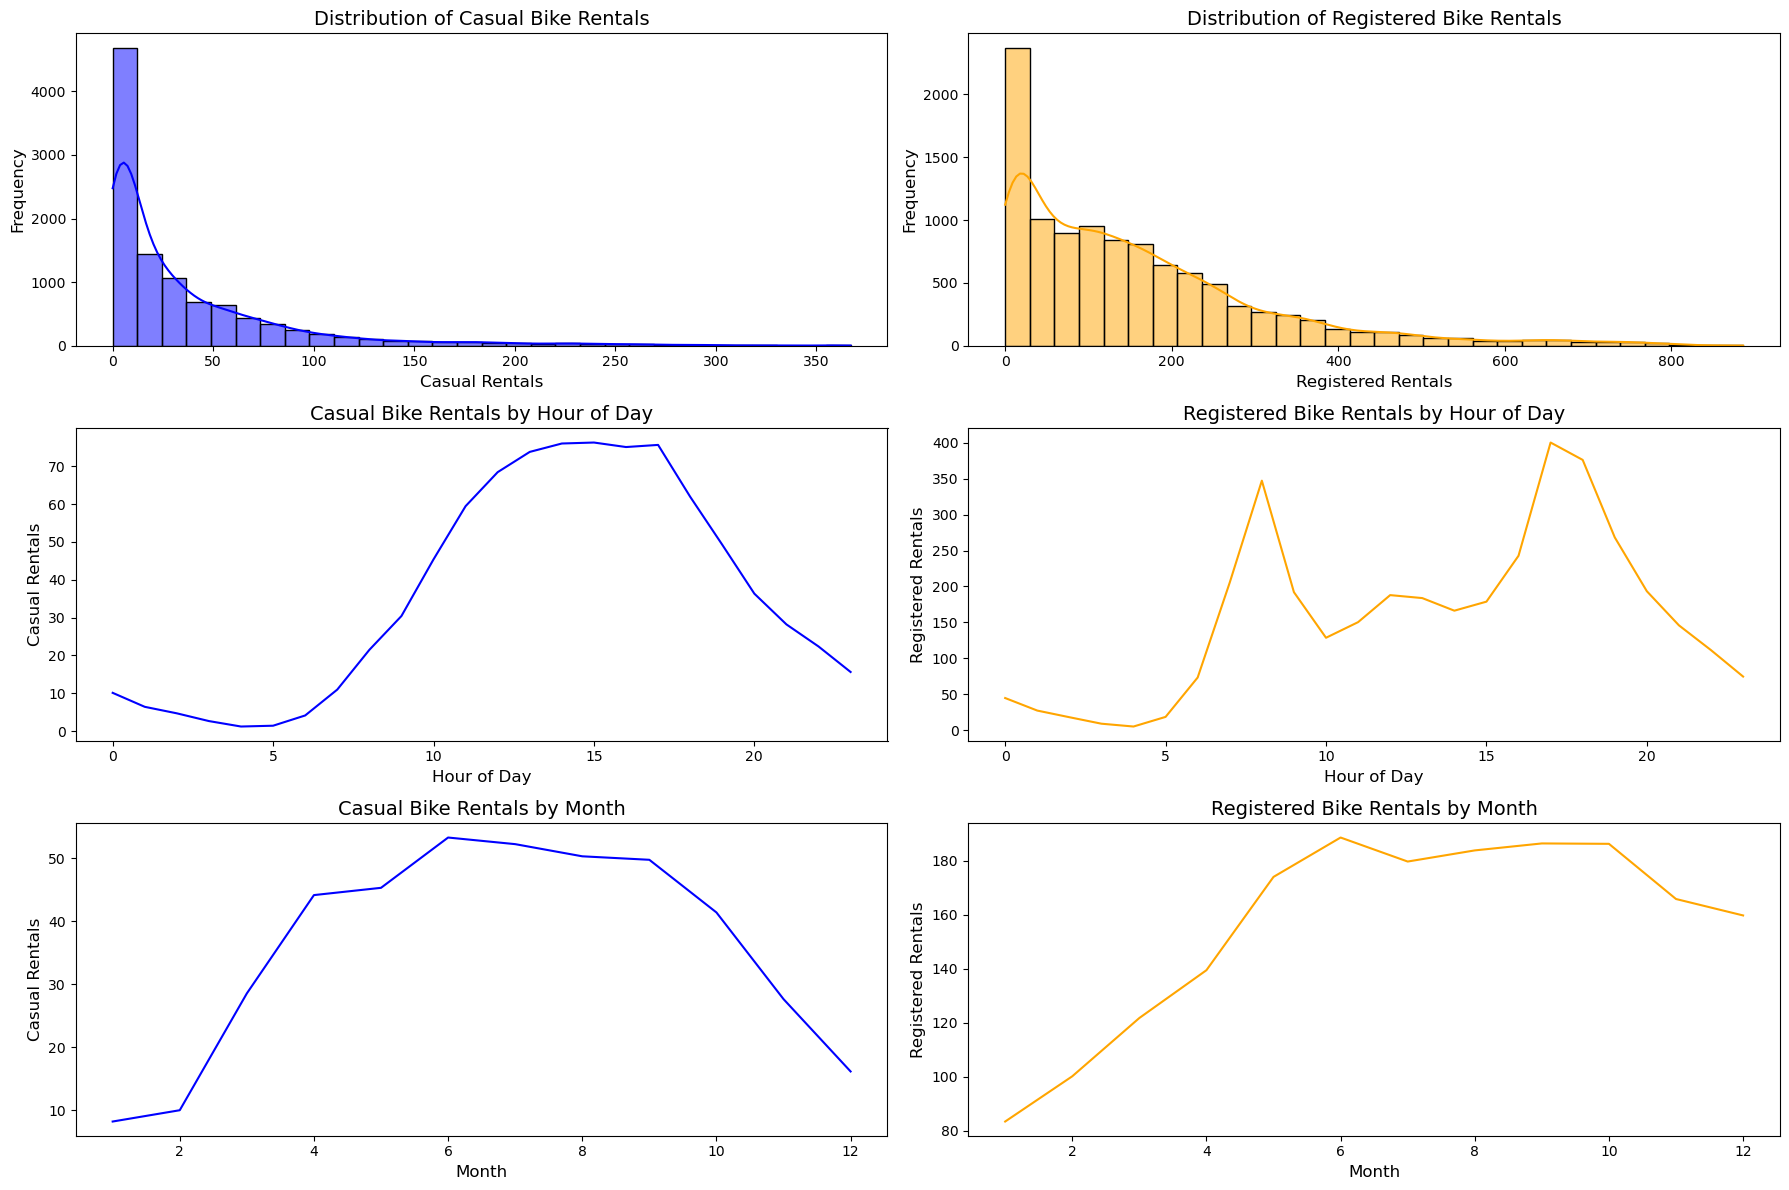

In [89]:
# Line plot for weather impact over months
fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

# Distribution of Casual Rentals
sns.histplot(train_df['casual'], kde=True, bins=30, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Casual Bike Rentals', fontsize=14)
axes[0].set_xlabel('Casual Rentals', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Distribution of Registered Rentals
sns.histplot(train_df['registered'], kde=True, bins=30, color='orange', ax=axes[1])
axes[1].set_title('Distribution of Registered Bike Rentals', fontsize=14)
axes[1].set_xlabel('Registered Rentals', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Casual Rentals by Hour
sns.lineplot(data=train_df, x='hour', y='casual', ci=None, color='blue', ax=axes[2])
axes[2].set_title('Casual Bike Rentals by Hour of Day', fontsize=14)
axes[2].set_xlabel('Hour of Day', fontsize=12)
axes[2].set_ylabel('Casual Rentals', fontsize=12)

# Registered Rentals by Hour
sns.lineplot(data=train_df, x='hour', y='registered', ci=None, color='orange', ax=axes[3])
axes[3].set_title('Registered Bike Rentals by Hour of Day', fontsize=14)
axes[3].set_xlabel('Hour of Day', fontsize=12)
axes[3].set_ylabel('Registered Rentals', fontsize=12)

# Casual Rentals by Month
sns.lineplot(data=train_df, x='month', y='casual', ci=None, color='blue', ax=axes[4])
axes[4].set_title('Casual Bike Rentals by Month', fontsize=14)
axes[4].set_xlabel('Month', fontsize=12)
axes[4].set_ylabel('Casual Rentals', fontsize=12)

# Registered Rentals by Month
sns.lineplot(data=train_df, x='month', y='registered', ci=None, color='orange', ax=axes[5])
axes[5].set_title('Registered Bike Rentals by Month', fontsize=14)
axes[5].set_xlabel('Month', fontsize=12)
axes[5].set_ylabel('Registered Rentals', fontsize=12)

# Save the plot as an image
plt.savefig('bike_rental_casual_and_registered.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

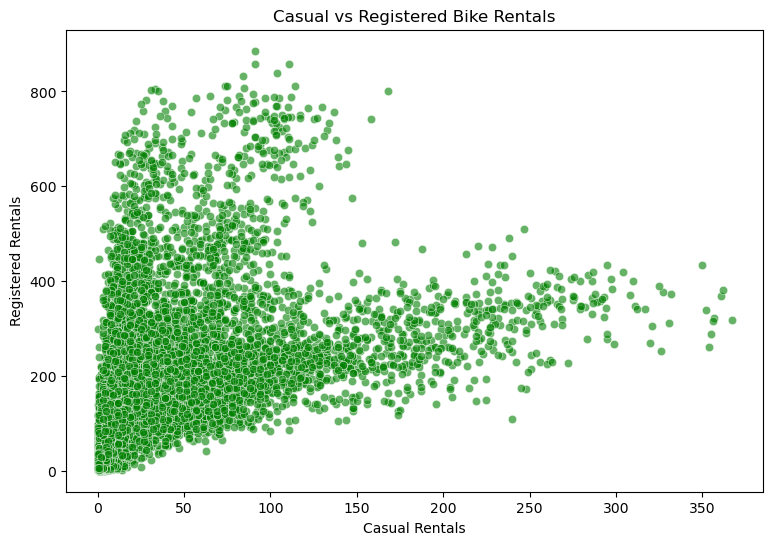

In [90]:
# Scatter plot for casual vs registered rentals
plt.figure(figsize=(9, 6))

sns.scatterplot(data=train_df, x='casual', y='registered', alpha=0.6, color='green')
plt.title('Casual vs Registered Bike Rentals')
plt.xlabel('Casual Rentals')
plt.ylabel('Registered Rentals')
plt.show()

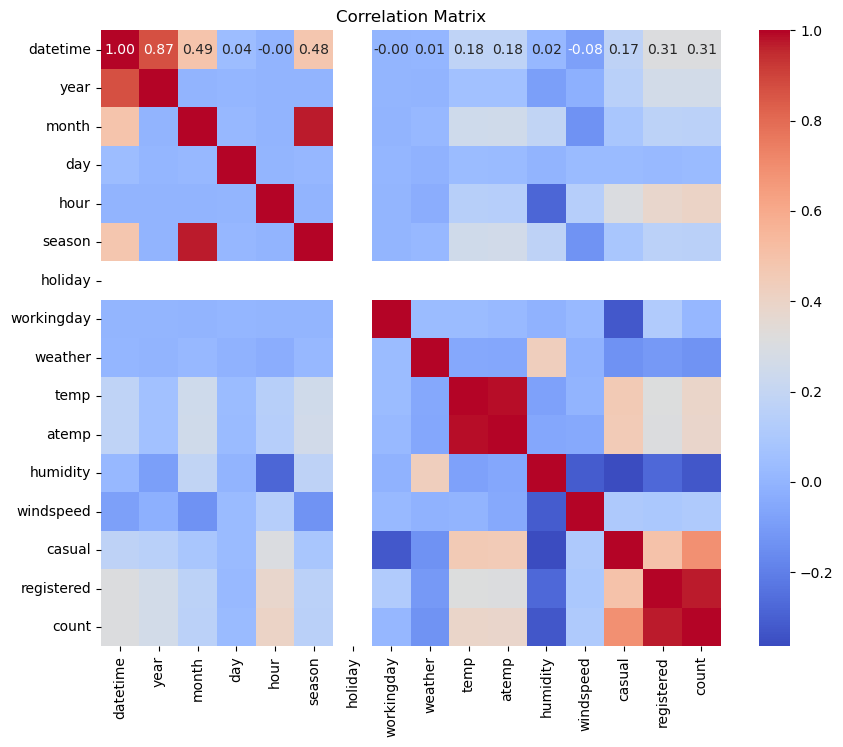

In [91]:
# Correlation matrix
correlation = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Test Dataset

In [93]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [94]:
# Convert InvoiceDate to DateTime format
test_df['datetime'] = pd.to_datetime(test_df['datetime'], format='mixed', dayfirst = False)

# Extract Years from the datetime
test_df['year'] = test_df['datetime'].dt.year

# Extract Months from the datetime
test_df['month'] = test_df['datetime'].dt.month

# Extract Days from the datetime
test_df['day'] = test_df['datetime'].dt.day

# Extract Hours from the datetime
test_df['hour'] = test_df['datetime'].dt.hour


# Rearrange Columns
test_df.insert(1, 'year', test_df.pop('year'))
test_df.insert(2, 'month', test_df.pop('month'))
test_df.insert(3, 'day', test_df.pop('day'))
test_df.insert(4, 'hour', test_df.pop('hour'))

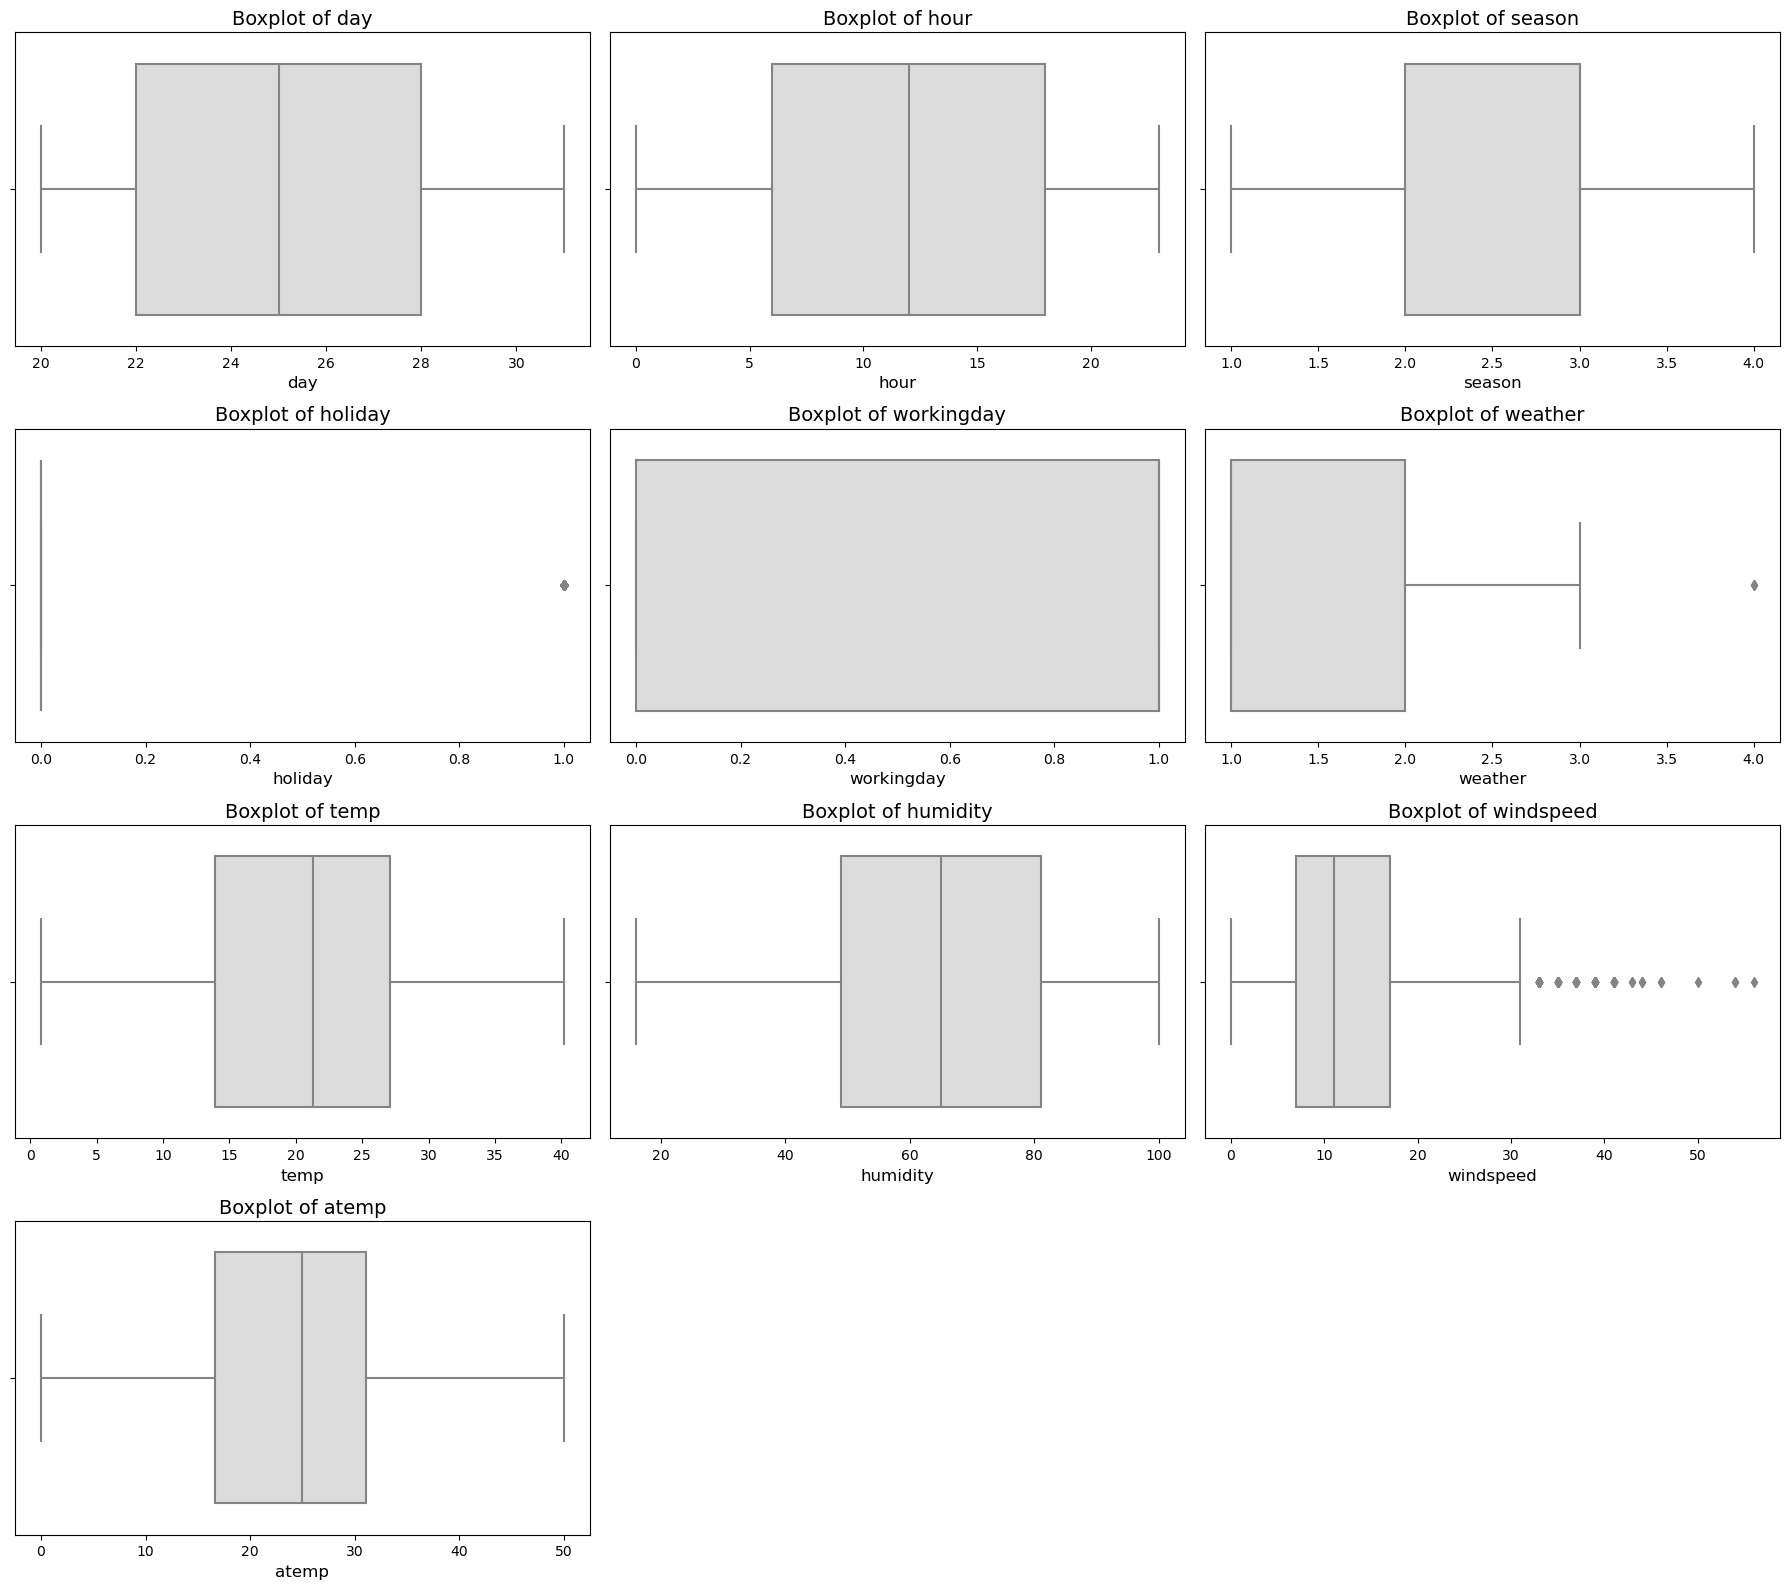

In [95]:
numerical_features = ['day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'atemp']

# Setting up a grid layout for 3 plots per row
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=test_df, x=feature, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].tick_params(labelsize=10)

# Remove extra subplots (if any)
for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

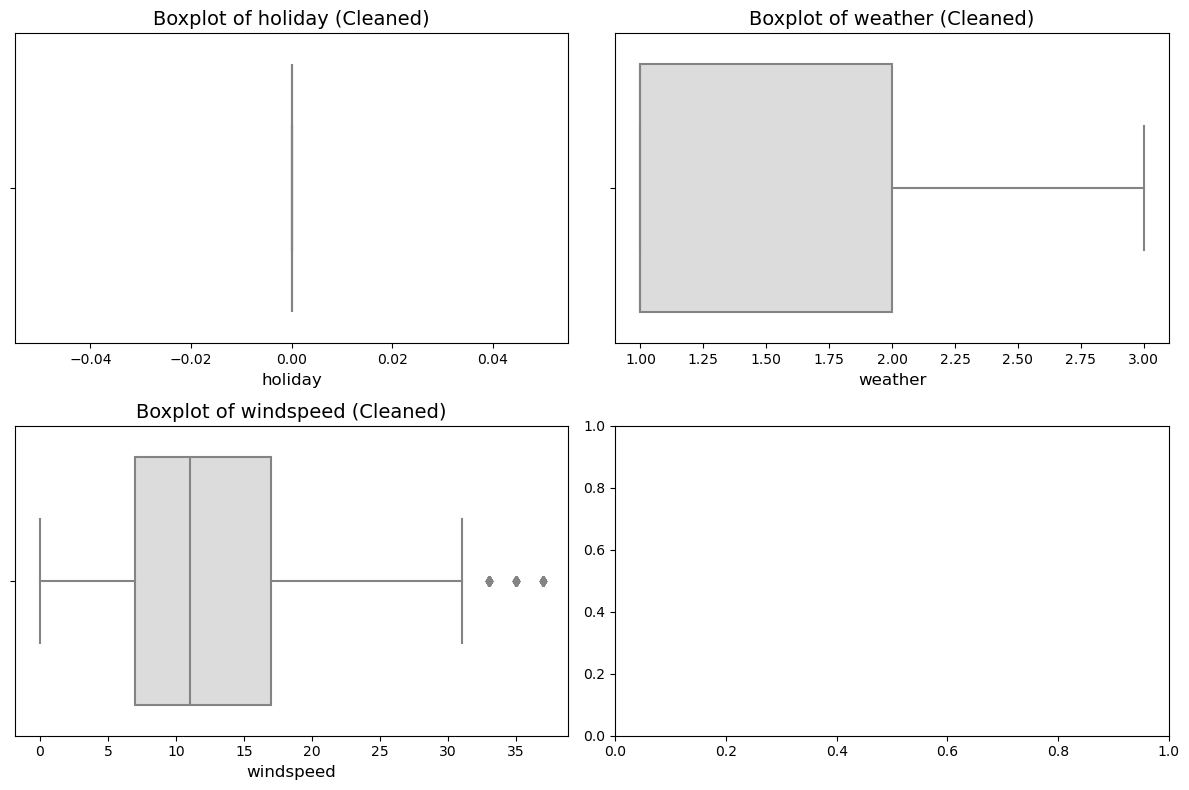

In [96]:
# Columns for outlier removal
columns_to_check = ['holiday', 'weather', 'windspeed']

# Calculate Z-scores for the specified columns
z_scores = np.abs(zscore(test_df[columns_to_check]))

# Create a mask for rows with all Z-scores <= 3 (not outliers)
non_outlier_mask = (z_scores <= 3).all(axis=1)

# Filter the DataFrame to remove outliers
test_outlier_removed = test_df[non_outlier_mask]

# Plot new boxplots for the removed outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot boxplots for the affected features
features_with_outliers = ['holiday', 'weather', 'windspeed']
for i, feature in enumerate(columns_to_check):
    sns.boxplot(data=test_outlier_removed, x=feature, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} (Cleaned)', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].tick_params(labelsize=10)

# Save the plot as image
plt.savefig('bike_rental_outliers_removed_distribution.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [97]:
test_df = test_outlier_removed

In [98]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6263 entries, 0 to 6492
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6263 non-null   datetime64[ns]
 1   year        6263 non-null   int32         
 2   month       6263 non-null   int32         
 3   day         6263 non-null   int32         
 4   hour        6263 non-null   int32         
 5   season      6263 non-null   int64         
 6   holiday     6263 non-null   int64         
 7   workingday  6263 non-null   int64         
 8   weather     6263 non-null   int64         
 9   temp        6263 non-null   float64       
 10  atemp       6263 non-null   float64       
 11  humidity    6263 non-null   int64         
 12  windspeed   6263 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(4), int64(5)
memory usage: 587.2 KB


In [99]:
#train_df.to_csv('cleaned_train_df.csv')
#test_df.to_csv('cleaned_test_df.csv')

## Model Training and Evaluation

In [101]:
copy_train_df = train_df.copy()

In [102]:
copy_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10487 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10487 non-null  datetime64[ns]
 1   year        10487 non-null  int32         
 2   month       10487 non-null  int32         
 3   day         10487 non-null  int32         
 4   hour        10487 non-null  int32         
 5   season      10487 non-null  int64         
 6   holiday     10487 non-null  int64         
 7   workingday  10487 non-null  int64         
 8   weather     10487 non-null  int64         
 9   temp        10487 non-null  float64       
 10  atemp       10487 non-null  float64       
 11  humidity    10487 non-null  int64         
 12  windspeed   10487 non-null  float64       
 13  casual      10487 non-null  int64         
 14  registered  10487 non-null  int64         
 15  count       10487 non-null  int64         
dtypes: datetime64[ns](1), float

In [103]:
# Pairplot of important features
#sns.pairplot(train_df[['year', 'hour', 'temp', 'atemp', 'humidity', 'casual', 'registered']], diag_kind='kde', palette='coolwarm')
#plt.show()

## Feature selection

In [109]:
from sklearn.feature_selection import SelectKBest, f_regression

# Define features and target variable
X = train_df.drop(columns=['count','datetime','casual','registered']) 
y = train_df['count']              

# Apply SelectKBest
kbest = SelectKBest(score_func=f_regression, k=7) 
X_kbest = kbest.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[kbest.get_support()]
print("Selected features:", selected_features)

Selected features: Index(['year', 'month', 'hour', 'season', 'temp', 'atemp', 'humidity'], dtype='object')


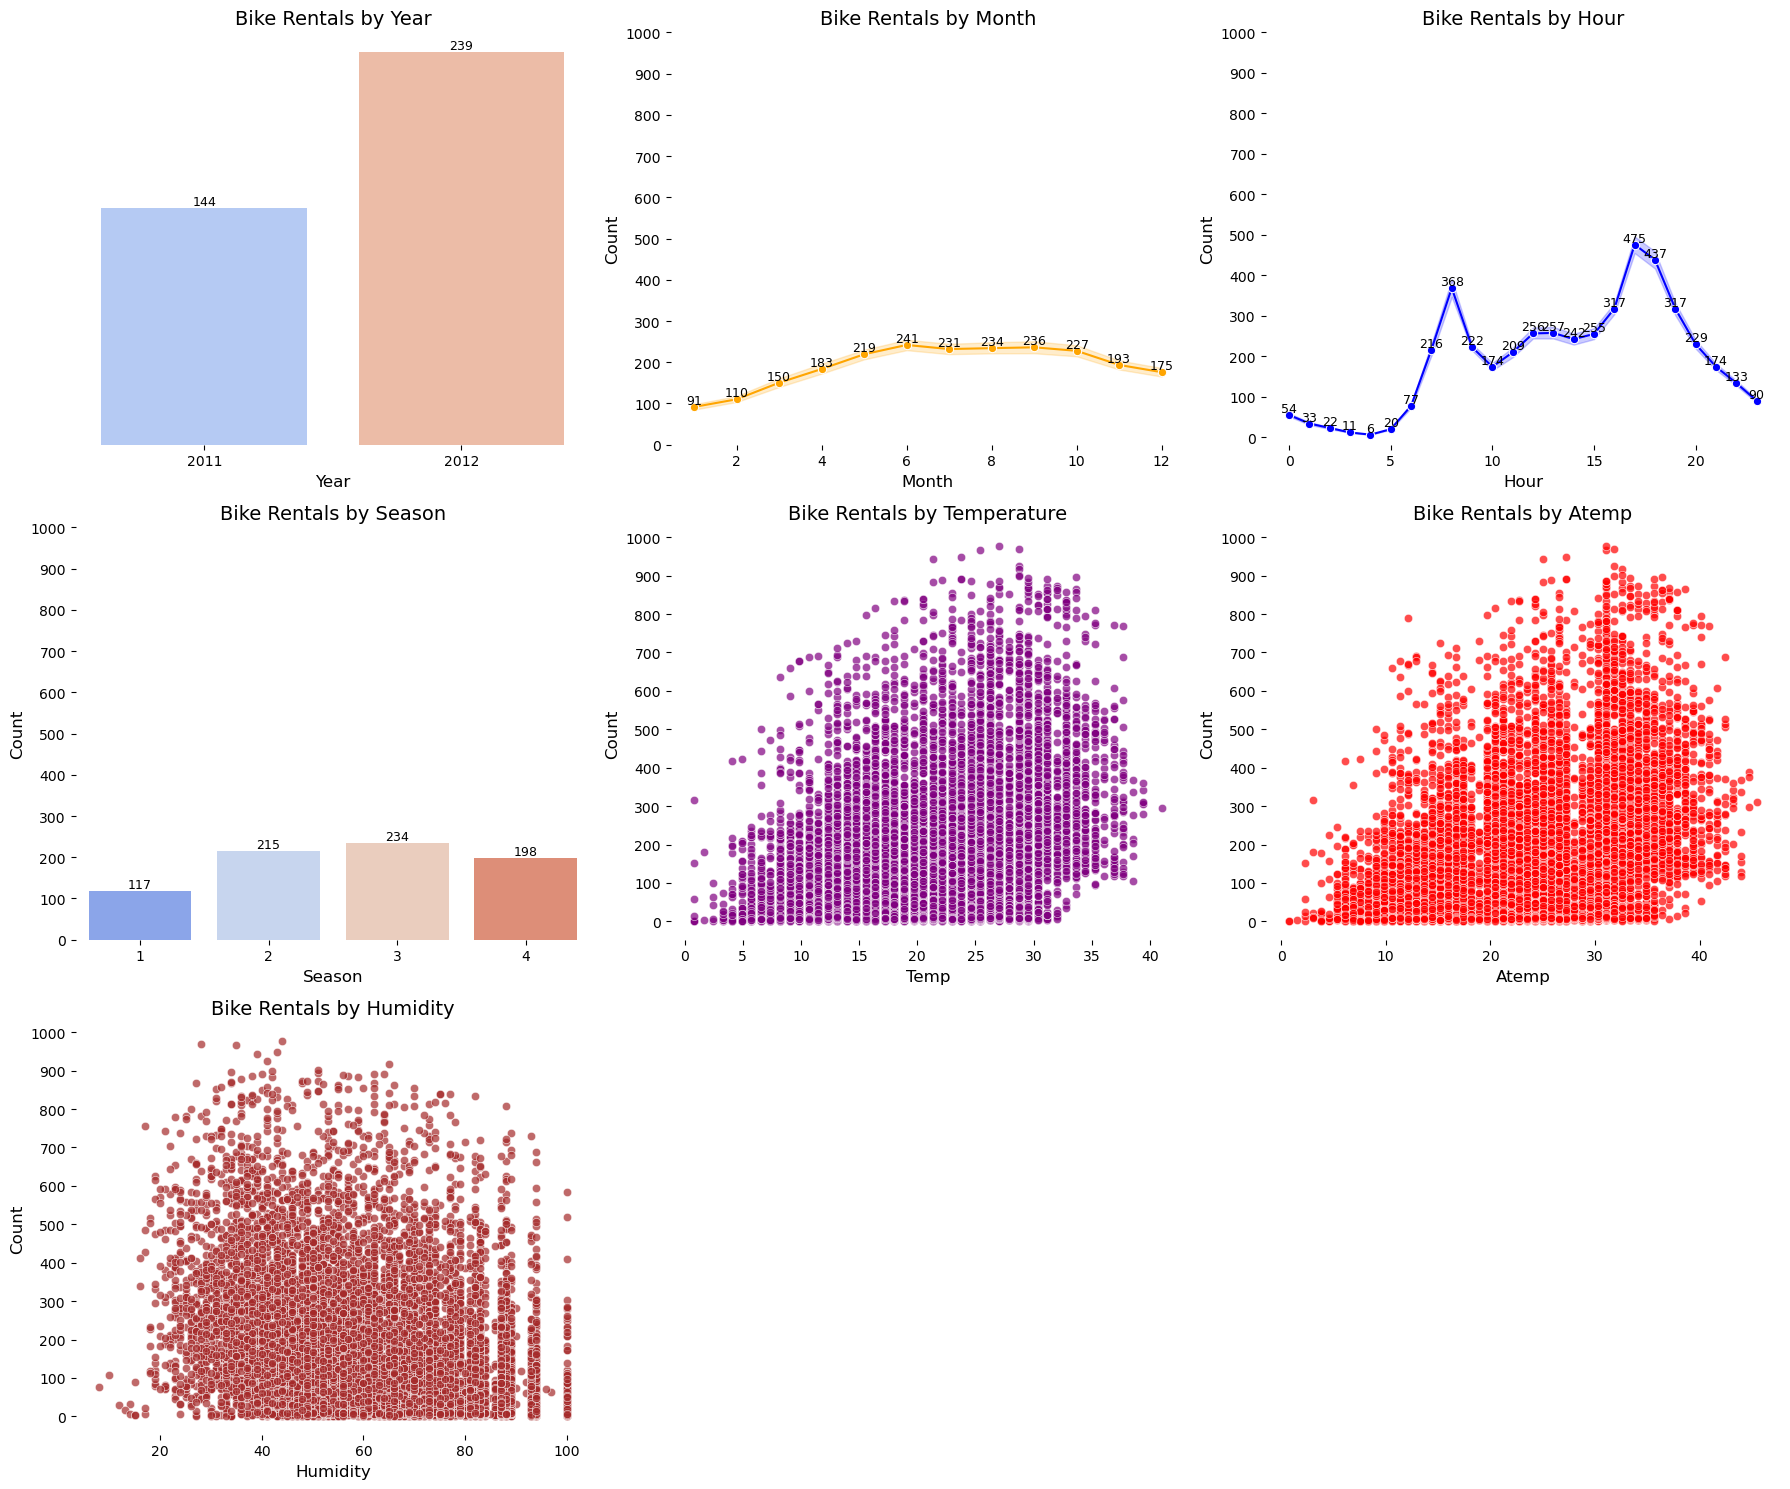

In [106]:
# Select important features
features = ['year', 'month', 'hour', 'season', 'temp', 'atemp', 'humidity']
titles = [
    'Bike Rentals by Year', 'Bike Rentals by Month',  'Bike Rentals by Hour',  'Bike Rentals by Season', 'Bike Rentals by Temperature',
    'Bike Rentals by Atemp', 'Bike Rentals by Humidity'
]
plot_styles = ['bar', 'line', 'line', 'bar', 'scatter', 'scatter', 'scatter']
colors = ['skyblue', 'orange', 'blue', 'green', 'purple', 'red', 'brown']

# Set up subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

# Loop through features
for i, feature in enumerate(features):
    ax = axes[i]
    
    if plot_styles[i] == 'bar':  # Bar plot for Year and Season
        feature_means = train_df.groupby(feature)['count'].mean()
        sns.barplot(x=feature_means.index, y=feature_means.values, palette='coolwarm', ax=ax)
        
        # Annotate bar plot
        for patch in ax.patches:
            ax.text(patch.get_x() + patch.get_width()/2., patch.get_height(), 
                     f'{int(patch.get_height()):,}', ha='center', va='bottom', fontsize=9)
        
        if feature == 'year':
            ax.set_ylabel(None)  # Remove y-axis labels
            ax.set_yticks([])  # Remove y-axis values
        else:
            ax.set_ylabel('Count', fontsize=12)  # Show y-axis labels
            ax.set_yticks(range(0, max(train_df['count']) + 100, 100)) 
        sns.despine(left=True, bottom=True)  # Remove spines
        ax.grid(False)  # Remove gridlines
    
    elif plot_styles[i] == 'line':  # Line plot for Month and Hour
        sns.lineplot(data=train_df, x=feature, y='count', marker='o', color=colors[i], ax=ax)
        
        # Annotate line plot
        feature_means = train_df.groupby(feature)['count'].mean()
        for x, y in zip(feature_means.index, feature_means.values):
            ax.text(x, y, f'{int(y):,}', ha='center', va='bottom', fontsize=9)
        
        ax.set_ylabel('Count', fontsize=12)  # Show y-axis labels
        ax.set_yticks(range(0, max(train_df['count']) + 100, 100)) 
        sns.despine(left=True, bottom=True)  # Remove spines
        ax.grid(False)  # Remove gridlines
    
    elif plot_styles[i] == 'scatter':  # Scatter plot for other features
        sns.scatterplot(data=train_df, x=feature, y='count', color=colors[i], alpha=0.7, ax=ax)
        
        ax.set_ylabel('Count', fontsize=12)  # Show y-axis labels
        ax.set_yticks(range(0, max(train_df['count']) + 100, 100))
        sns.despine(left=True, bottom=True)  # Remove spines
        ax.grid(False)  # Remove gridlines
    
    # Customize each subplot
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel(feature.capitalize(), fontsize=12)

# Remove any empty subplots (if fewer than 9)
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Save the plot as an image
plt.savefig('best_features.png', dpi=300, bbox_inches='tight')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Split dataset to train and test

In [111]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=0.2, random_state=42)

## Scale Splitted train and test data with Standard Scaler

In [113]:
from sklearn.preprocessing import StandardScaler

# apply standard scaler on the train and test dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Cross Validation

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# model selection
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf'),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

#Cross-validate each model
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')    
    # Convert negative MSE to positive
    mse_scores = -scores
    
    # Store results
    results[name] = {
        "scores": mse_scores,
        "mean_mse": np.mean(mse_scores),
        "std_deviation": np.std(mse_scores)
    }

    # Print results
    print(f"{name} - Cross-Validation MSE: {mse_scores}")
    print(f"{name} - Mean MSE: {np.mean(mse_scores):.2f}")
    print(f"{name} - Standard Deviation: {np.std(mse_scores):.2f}\n")

Evaluating Linear Regression...
Linear Regression - Cross-Validation MSE: [19226.42763683 21595.60507325 20372.32370921 20272.10578558
 19921.87026337]
Linear Regression - Mean MSE: 20277.67
Linear Regression - Standard Deviation: 771.71

Evaluating SVR...
SVR - Cross-Validation MSE: [18640.49748635 21954.45639415 20364.94817743 20116.77382628
 19042.69150413]
SVR - Mean MSE: 20023.87
SVR - Standard Deviation: 1160.05

Evaluating Random Forest...
Random Forest - Cross-Validation MSE: [8059.44682591 8109.92392914 7855.36061255 7640.06401052 8394.01760456]
Random Forest - Mean MSE: 8011.76
Random Forest - Standard Deviation: 253.24



## Linear Regression

In [117]:
# training lr model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)

# Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Metrics:\nMAE: {mae_lr:.2f}, MSE: {mse_lr:.2f}, R²: {r2_lr:.2f}")

Linear Regression Metrics:
MAE: 106.30, MSE: 20378.73, R²: 0.40


## Support Vector Regression

In [119]:
#training SVR
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train)

# Predictions and metrics
y_pred_svr = svr.predict(X_test_scaled)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR Metrics:\nMAE: {mae_svr:.2f}, MSE: {mse_svr:.2f}, R²: {r2_svr:.2f}")


SVR Metrics:
MAE: 92.59, MSE: 20582.15, R²: 0.40


## Random Forest Regressor

In [121]:
#training rf model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions and metrics
y_pred_rf = rf.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Metrics:\nMAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")


Random Forest Metrics:
MAE: 57.78, MSE: 8158.88, R²: 0.76


## Hyper parameter tunning

In [123]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [10, 20, None], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['auto', 'sqrt', 'log2'] 
}
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=3, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate the model
y_pred = best_rf.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Metrics after Tuning:\nMAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Metrics after Tuning:
MAE: 57.36, MSE: 7608.28, R²: 0.78


## Comparing model performance

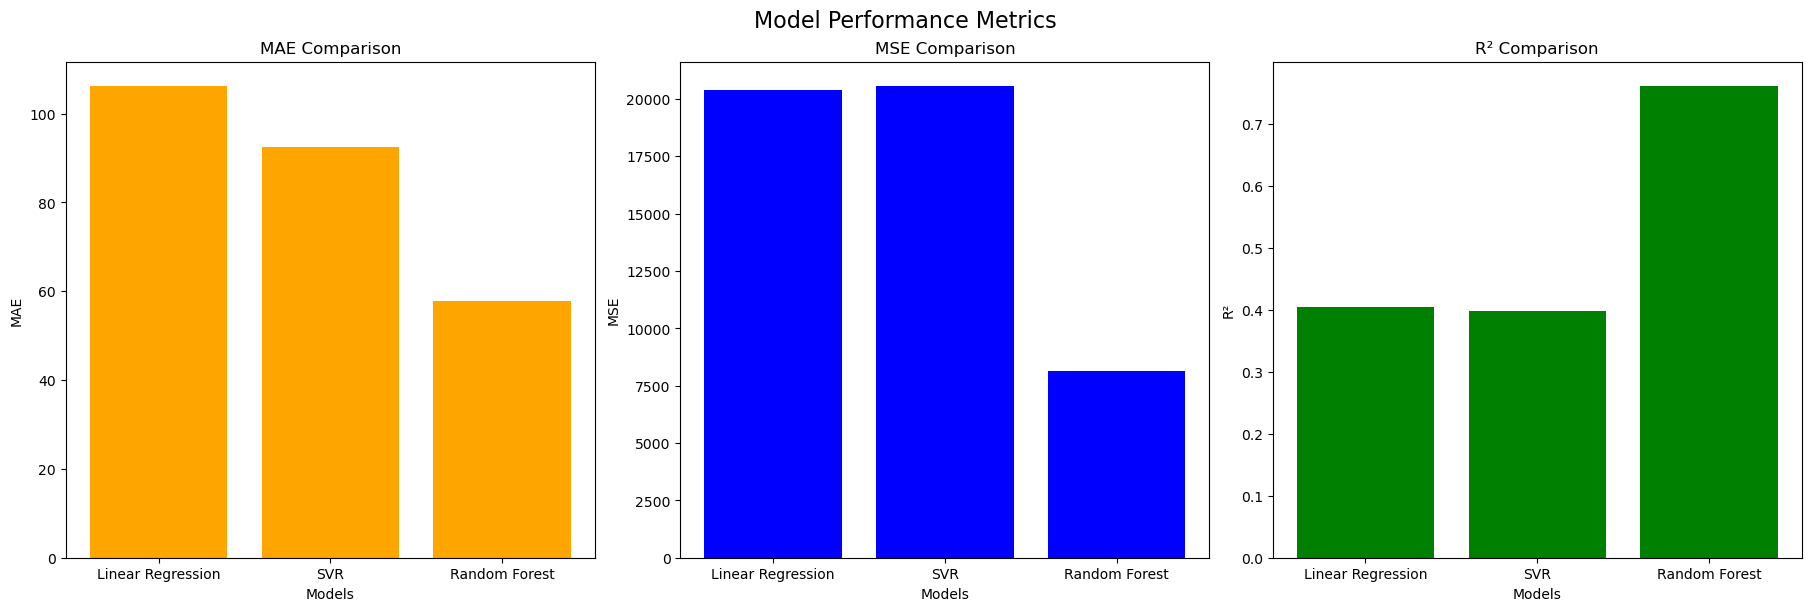

In [153]:
# Error metrics
models = ['Linear Regression', 'SVR', 'Random Forest']
mae_values = [mae_lr, mae_svr, mae_rf]
mse_values = [mse_lr, mse_svr, mse_rf]
r2_values = [r2_lr, r2_svr, r2_rf]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Plot MAE
axs[0].bar(models, mae_values, color='orange')
axs[0].set_title('MAE Comparison')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('Models')

# Plot MSE
axs[1].bar(models, mse_values, color='blue')
axs[1].set_title('MSE Comparison')
axs[1].set_ylabel('MSE')
axs[1].set_xlabel('Models')

# Plot R²
axs[2].bar(models, r2_values, color='green')
axs[2].set_title('R² Comparison')
axs[2].set_ylabel('R²')
axs[2].set_xlabel('Models')

# Save the plot as an image
plt.savefig('model_comparison_1.png', dpi=300, bbox_inches='tight')

# Show plot
plt.suptitle("Model Performance Metrics", fontsize=16)
plt.show()

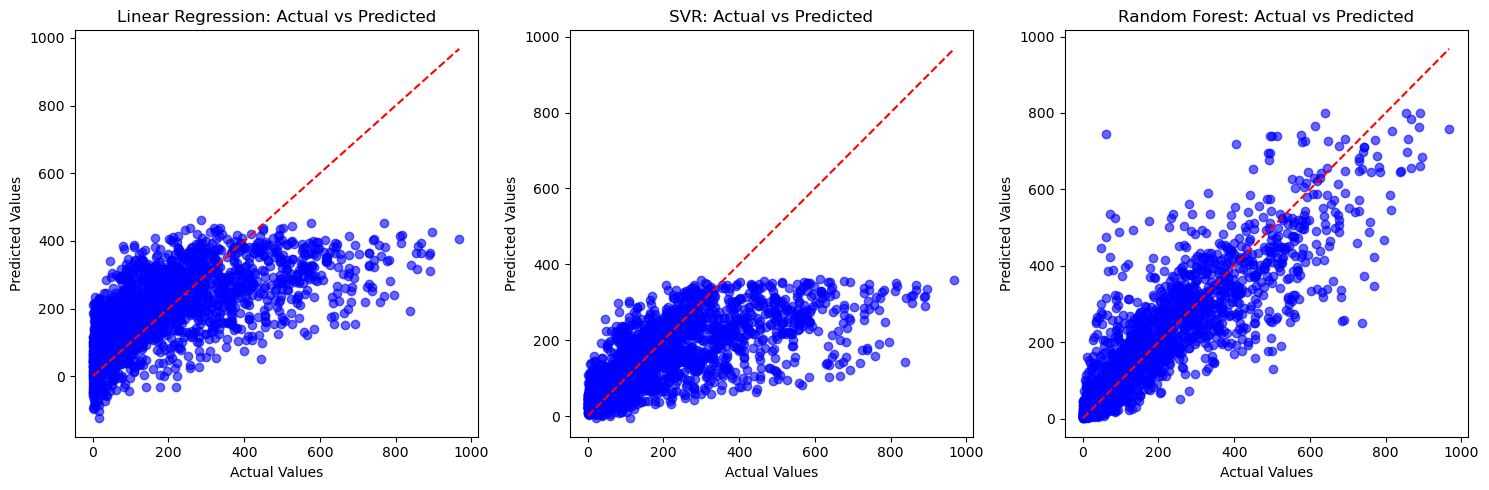

In [151]:
# scatter plots for each model
plt.figure(figsize=(15, 5))

models = ['Linear Regression', 'SVR', 'Random Forest']
y_preds = [y_pred_lr, y_pred_svr, y_pred_rf]

for i, (name, y_pred) in enumerate(zip(models, y_preds), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
    plt.title(f"{name}: Actual vs Predicted")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")

# Save the plot as an image
plt.savefig('model_comparison_2.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Save Best Model

In [128]:
import joblib

#Save the scaler
joblib.dump(scaler, 'scaler.pk1')

# Save the model
joblib.dump(best_rf, 'random_forest_model.pk1')
print("Model saved as 'random_forest_model.pk1'")

Model saved as 'random_forest_model.pk1'


## Test Model

In [130]:
scaler = joblib.load('scaler.pkl')
model = joblib.load('random_forest_model.pkl')


features = ['year', 'month', 'hour', 'season', 'temp', 'atemp', 'humidity']
X_new = test_df[features]

#scale the test data
X_new_scaled = scaler.transform(X_new)

# Predict bike rental count
test_df['count'] = model.predict(X_new_scaled)

# Save the new dataset with predictions
test_df.to_csv('test_df with count.csv', index=False)

test_df

,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-20 00:00:00,2011,1,20,0,1,0,1,1,10.66,11.365,56,26.0027,20.509192
1,2011-01-20 01:00:00,2011,1,20,1,1,0,1,1,10.66,13.635,56,0.0000,19.885254
2,2011-01-20 02:00:00,2011,1,20,2,1,0,1,1,10.66,13.635,56,0.0000,14.976787
3,2011-01-20 03:00:00,2011,1,20,3,1,0,1,1,10.66,12.880,56,11.0014,7.997426
4,2011-01-20 04:00:00,2011,1,20,4,1,0,1,1,10.66,12.880,56,11.0014,2.366082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,2012,12,31,19,1,0,1,2,10.66,12.880,60,11.0014,287.607254
6489,2012-12-31 20:00:00,2012,12,31,20,1,0,1,2,10.66,12.880,60,11.0014,196.233525
6490,2012-12-31 21:00:00,2012,12,31,21,1,0,1,1,10.66,12.880,60,11.0014,128.413169
6491,2012-12-31 22:00:00,2012,12,31,22,1,0,1,1,10.66,13.635,56,8.9981,117.041396


In [149]:
# Load saved Model and Scaler
try:
    model = joblib.load('random_forest_model.pkl')
    scaler = joblib.load('scaler.pkl')  # Load the scaler used during training
    print("Model and scaler loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}")
    raise
    
# Create Inputs
year = int(input("Enter the year : "))
month = int(input("Enter the months: "))
hour = int(input("Enter the hour (0-23): "))
season = int(input("Enter the season: "))
temp = float(input("Enter the temperature (°C): "))
atemp = float(input("Enter the average temperature (°C): "))
humidity = float(input("Enter the humidity (%): "))

# Input validation
valid_inputs = True

if not (2000 <= year <= 2024):
    print("Error: Year must be between 2000 and 2024.")
    valid_inputs = False
if not (0 <= hour <= 23):
    print("Error: Hour must be between 0 and 23.")
    valid_inputs = False
if humidity < 0 or humidity > 100:
    print("Error: Humidity must be between 0 and 100.")
    valid_inputs = False
if not (0 <= season <= 4):
    print("Error: Season must be 0 or higher.")
    valid_inputs = False
if not (0 <= month <= 19):
    print("Error: Month must be 0 or higher.")
    valid_inputs = False

# Make a prediction if all inputs are valid
if valid_inputs:
    # Arrange input data
    input_data = np.array([[year, month, hour, season, temp, atemp, humidity]])
    
    # Scale the input data
    try:
        scaled_input_data = scaler.transform(input_data)  # Apply scaling
        prediction = model.predict(scaled_input_data)     # Apply Model
        print(f"Predicted Bike Rentals: {int(prediction[0])}")
    except Exception as e:
        print("Error making prediction:", e)
else:
    print("Please correct the input errors before predicting.")

Model and scaler loaded successfully!


Enter the year :  2023
Enter the months:  5
Enter the hour (0-23):  17
Enter the season:  1
Enter the temperature (°C):  14
Enter the average temperature (°C):  12
Enter the humidity (%):  56


Predicted Bike Rentals: 417
